In [1]:
%%latex
\tableofcontents

<IPython.core.display.Latex object>

# Ambulance_Dispatch_2024_06_Analyze_Results

# Inputs

- The previous notebook build models and wrote the results in the "Big_Files" folder outside this repository
- The name of each results file looks like "BRFC_alpha_0_5_Hard_Run_0.csv"
- The results are four columns: 
    - Index (not really relevant)
    - y_test, the (binary) value of the target variable, HOSPITAL
        - 0 Didn't go to hospital
        - 1 Went to hospital
    - y_proba, the model's assessment, given the values of the other features in the sample, of the probability  in the real interval $y \in [0,1]$ that this person went to the hospital
    - y_pred, the model's prediction, using threshold $\theta = 0.5$, that this person went to the hospital.  This value is y_proba rounded.  (also not really relevant)
    
 |  | y_test | y_proba | y_pred |
 |---|---|---|---|
 | 0 | 0 | 0.17 | 0 |
 | 1 | 0 | 0.19 | 0 |
 | 2 | 0 | 0.44 | 0 |
 | 3 | 0 | 0.23 | 0 |
 | 4 | 0 | 0.25 | 0 |
 | 5 | 0 | 0.31 | 0 |
 | 6 | 0 | 0.35 | 0 |
 | 7 | 1 | 0.74 | 1 |
 | 8 | 0 | 0.13 | 0 |

# Understanding y_proba

- The y_proba value for a sample sounds like the probability that the sample belongs to the positive class, but alas, it is not.
- We have created a metric, Pos/(Neg + Pos), that calculates the probability in bands of y_proba.
- The y_proba values (generally) increase with the probability that the sample belongs to the positive class.  

# Outputs

## A Spreadsheet for each Model with Model Output in Bands
- The example table below is from BRFC_alpha_0_7_Hard_Run_0_1000_Slices.csv
    - Sorted by increasing y_proba
    - $\theta$ is the value of y_proba that we choose as the decision threshold, so we will use those two terms interchangeably.
    - Grouped into bands y_proba $\in$ [min, max] with at least one thousand samples from the negative class (HOSPITAL==0) and at least one thousand samples from the positive class (HOSPITAL==1).  Grouped from the bottom of the list with the top row perhaps having less than a thousand of each class.  
    - The choice of 1000 is rather arbitrary, but after trial and error we chose it to give detail while smoothing out the randomness of the distribution of negative and positive samples.
    - Having more than 1000 of both classes in a band indicates that more than one sample had the y_proba==min, because the grouping does not split samples with the same value.  If the min of one band is the max of the previous, that's due to rounding for this table.
    - min and max are the y_proba values at the ends of the band
    - Neg and Pos are the number of samples of the negative and positive clases in the band
    - Pos/(Neg+Pos) is one of our decision threshold metrics, the probability that a sample in this band is in the positive class.  If we set the decision threshold $\theta$ in this band of y_proba, we call this value the "marginal probability" or mProba, of a crash person needing an ambulance.
        - Bands 16-21 illustrate that mProb is not always an increasing function of $\theta$.  
        - At band 51, $\theta \in [0.77, 0.78)$, mProba = 50%, our target for this decision thresholds.
    - TN is the cumulative sum of Neg, and FN is the cumulative sum of Pos.
    - Precision = TP/(FP+TP) is another of our decision threshold metrics. 
        - Precision is the proportion of ambulances sent that are actually needed
        - Precision is not necessarily a nondecreasing function of $\theta$, but with the class imbalance, the distribution of the Neg towards y_proba==0 and Pos towards y_proba==1, and the large bands that smooth the distribution, precision is generally an increasing function of $\theta$.  
        - Index 54 is where Precision is closest to our target, Prec = 0.667.
        - This list has length 63 rows.  In index 62, FP and TP are zero, so Prec==NaN.  
    - Recall = TP/(FN+TP) = TP/P
        - Recall is the proportion of sent ambulances that are needed.
        - Recall is a nonincreasing function of $\theta$.
        - For each decision threshold metric, we will find the value of $\theta$ that gives the target value, then choose the model that give the highest recall.  
        - Choosing the highest recall is the same as choosing the highest TP, because N is the same in all of our models.
    - FP/P is the last of our decision threshold metrics. 
        - FP/P is the increase in number of ambulances sent if a locality implements immediate ambulance dispatch.
        - FP/P is a nonincreasing function of $\theta$.  
        - At Index 58, FP/P is closest to its target value, 0.05.  Setting $\theta$ there would cap the cost increase at 5%.
    - The length of this list is 63 rows.  
    
    
    | Index | min | max | Neg | Pos | Pos/(Neg+Pos) | TN | FP | FN | TP | Prec | Rec | FP/P	| 
    |---|---|---|---|---|---|---|---|---|---|---|---|---|
    | 0 | 0 | 0.0995 | 18729 | 156 | 0.0083 | 18729 | 657715 | 156 | 126100 | 0.1609 | 0.9988 | 5.2094 |
    | 1 | 0.1 | 0.1791 | 56799 | 1045 | 0.0181 | 75528 | 600916 | 1201 | 125055 | 0.1723 | 0.9905 | 4.7595 |
    | 2 | 0.18 | 0.2194 | 41326 | 1150 | 0.0271 | 116854 | 559590 | 2351 | 123905 | 0.1813 | 0.9814 | 4.4322 |
    | 3 | 0.22 | 0.2498 | 35354 | 1216 | 0.0333 | 152208 | 524236 | 3567 | 122689 | 0.1896 | 0.9717 | 4.1522 |
    | 4 | 0.25 | 0.2698 | 25635 | 1021 | 0.0383 | 177843 | 498601 | 4588 | 121668 | 0.1962 | 0.9637 | 3.9491 |
    | 5 | 0.27 | 0.2896 | 26768 | 1279 | 0.0456 | 204611 | 471833 | 5867 | 120389 | 0.2033 | 0.9535 | 3.7371 |
    | ... |  |  |  |  |  |  |  |  |  |  |  |  |
    | 16 | 0.42 | 0.4298 | 13318 | 1454 | 0.0984 | 399220 | 277224 | 20630 | 105626 | 0.2759 | 0.8366 | 2.1957 |
    | 17 | 0.43 | 0.44 | 13124 | 1579 | 0.1074 | 412344 | 264100 | 22209 | 104047 | 0.2826 | 0.8241 | 2.0918 |
    | 18 | 0.44 | 0.4498 | 13054 | 1540 | 0.1055 | 425398 | 251046 | 23749 | 102507 | 0.2899 | 0.8119 | 1.9884 |
    | 19 | 0.45 | 0.46 | 12661 | 1721 | 0.1197 | 438059 | 238385 | 25470 | 100786 | 0.2972 | 0.7983 | 1.8881 |
    | 20 | 0.46 | 0.4696 | 12252 | 1643 | 0.1182 | 450311 | 226133 | 27113 | 99143 | 0.3048 | 0.7853 | 1.7911 |
    | 21 | 0.47 | 0.4798 | 12181 | 1792 | 0.1282 | 462492 | 213952 | 28905 | 97351 | 0.3127 | 0.7711 | 1.6946 |
    | ... |  |  |  |  |  |  |  |  |  |  |  |  |
    | 50 | 0.76 | 0.7698 | 2364 | 2289 | 0.4919 | 656972 | 19472 | 94826 | 31430 | 0.6175 | 0.2489 | 0.1542 |
    | 51 | 0.77 | 0.78 | 2307 | 2372 | 0.5069 | 659279 | 17165 | 97198 | 29058 | 0.6286 | 0.2302 | 0.136 |
    | 52 | 0.78 | 0.7898 | 2072 | 2210 | 0.5161 | 661351 | 15093 | 99408 | 26848 | 0.6401 | 0.2126 | 0.1195 |    
    | ... |  |  |  |  |  |  |  |  |  |  |  |  |
    | 54 | 0.8 | 0.8099 | 1802 | 2157 | 0.5448 | 665048 | 11396 | 103790 | 22466 | 0.6635 | 0.1779 | 0.0903 |
    | 55 | 0.81 | 0.8198 | 1626 | 2170 | 0.5717 | 666674 | 9770 | 105960 | 20296 | 0.675 | 0.1608 | 0.0774 |
    | ... |  |  |  |  |  |  |  |  |  |  |  |  |
    | 56 | 0.82 | 0.8298 | 1429 | 2045 | 0.5887 | 668103 | 8341 | 108005 | 18251 | 0.6863 | 0.1446 | 0.0661 |
    | 57 | 0.83 | 0.8398 | 1362 | 1975 | 0.5918 | 669465 | 6979 | 109980 | 16276 | 0.6999 | 0.1289 | 0.0553 |
    | 58 | 0.84 | 0.8495 | 1165 | 1929 | 0.6235 | 670630 | 5814 | 111909 | 14347 | 0.7116 | 0.1136 | 0.046 |
    | 59 | 0.85 | 0.8696 | 1959 | 3571 | 0.6458 | 672589 | 3855 | 115480 | 10776 | 0.7365 | 0.0854 | 0.0305 |
    | 60 | 0.87 | 0.889 | 1462 | 2940 | 0.6679 | 674051 | 2393 | 118420 | 7836 | 0.7661 | 0.0621 | 0.019 |
    | 61 | 0.89 | 0.9199 | 1388 | 3566 | 0.7198 | 675439 | 1005 | 121986 | 4270 | 0.8095 | 0.0338 | 0.008 |
    | 62 | 0.92 | 1 | 1005 | 4270 | 0.8095 | 676444 | 0 | 126256 | 0 | nan | 0 | 0 |

    <br><br>
- The table below is from LogReg_alpha_balanced_Medium_Run_0_1000_Slices.csv.
    - Note that the last row has FP=0 and TP=0, because we're not sending any ambulances, so Precision is NaN.
    - Precision is a generally increasing function of the decision threshold $\theta$, so the next to last row gives the maximum value of Prec = 0.5667, telling us that, with this model algorithm with these hyperparameters on the Medium features, there is no decision threshold where the target of Prec = 0.667 is achieved.
    - If we cut it into smaller bands, we might get a band with Prec $\approx$ 0.667, but the model would immediately dispatch so few ambulances that the benefit would not be worth the project overhead.

| Index | min | max | Neg | Pos | Pos/(Neg+Pos) | TN | FP | FN | TP | Prec | Rec | FP/P	| 
|---|---|---|---|---|---|---|---|---|---|---|---|---|
| 0 | 0.0397 | 0.1794 | 24475 | 773 | 0.0306 | 24475 | 651969 | 773 | 125483 | 0.1614 | 0.9939 | 5.1639 |
| 1 | 0.1794 | 0.2167 | 23510 | 1000 | 0.0408 | 47985 | 628459 | 1773 | 124483 | 0.1653 | 0.986 | 4.9777 |
| 2 | 0.2167 | 0.24 | 18987 | 1000 | 0.05 | 66972 | 609472 | 2773 | 123483 | 0.1685 | 0.978 | 4.8273 |
| ... |||||||||||||
| 123 | 0.8777 | 0.8893 | 1000 | 1038 | 0.5093 | 674444 | 2000 | 123816 | 2440 | 0.5495 | 0.0193 | 0.0158 |
| 124 | 0.8893 | 0.9057 | 1000 | 1132 | 0.531 | 675444 | 1000 | 124948 | 1308 | 0.5667 | 0.0104 | 0.0079 |
| 125 | 0.9057 | 0.9606 | 1000 | 1308 | 0.5667 | 676444 | 0 | 126256 | 0 | nan | 0 | 0 |

## One Spreadsheet for each Decision Threshold Metric
- The table below is from ../Analyze_Proba/Run_0/Prec_0_667.csv
    - One row for each model, showing the decision threshold $\theta$ where the model gets the decision metric closest to the target.
    - It has been filtered (outside this notebook; we did it in Excel) to only show rows whose Prec is within 0.02 of 0.667, because many models fail to even get close to the target value of the decision threshold metric.  See at the bottom of the table the Logistic Regression model on the Medium feature set that only got to Prec = 0.531; that model would send no ambulances.
    - It was then sorted by decreasing recall, Rec = TP/(TP+FN) = TP/P, which is the same as decreasing TP because P is the same in all of these models
    - The first row shows that for the Balanced Random Forest Classifier with $\alpha = 0.7$ on the Hard features, for y_pred $\in [0.8, 0.8099]$, there were 1.802 negative samples (y_test==0) and 2,157 positive samples (y_test==1).
    - If we put the decision threshold here around 0.8, we will 
        - Correctly not send ambulances to 665,048 people who do no need them (TN), 
        - Incorrectly send ambulances to 11,396 people who do not need them (FP), 
        - Incorrectly not immediately send ambulances to 103,790 people who need them (FN), but will send the ambulance later after an eyewitness report, 
        - Correctly immediately send ambulances to 22,466 people who need them (TP)

        Index | len | Filename | min | max | Neg | Pos | Pos/(Neg+Pos) | TN | FP | FN | TP | Prec | Rec | FP/P	| 
        |---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
        | 54 | 63 | BRFC_alpha_0_7_Hard_Run_0 | 0.8 | 0.8099 | 1,802 | 2,157 | 0.5448 | 665,048 | 11,396 | 103,790 | 22,466 | 0.6635 | 0.1779 | 0.0903 |
        | 53 | 62 | BRFC_alpha_0_5_Hard_Run_0 | 0.8 | 0.8097 | 1,778 | 2,251 | 0.5587 | 665,260 | 11,184 | 104,033 | 22,223 | 0.6652 | 0.176 | 0.0886 |
        | 55 | 64 | BRFC_alpha_0_9_Hard_Run_0 | 0.8 | 0.8099 | 1,760 | 2,079 | 0.5415 | 665,328 | 11,116 | 104,539 | 21,717 | 0.6614 | 0.172 | 0.088 |
        | 55 | 64 | BRFC_alpha_balanced_Hard_Run_0 | 0.81 | 0.8199 | 1,685 | 2,203 | 0.5666 | 666,074 | 10,370 | 105,504 | 20,752 | 0.6668 | 0.1644 | 0.0821 |
        | 54 | 63 | BRFC_alpha_0_6_Hard_Run_0 | 0.81 | 0.82 | 1,696 | 2,169 | 0.5612 | 666,442 | 10,002 | 105,693 | 20,563 | 0.6728 | 0.1629 | 0.0792 |
        | 56 | 65 | BRFC_alpha_0_85_Hard_Run_0 | 0.81 | 0.82 | 1,607 | 2,202 | 0.5781 | 666,215 | 10,229 | 105,732 | 20,524 | 0.6674 | 0.1626 | 0.081 |
        | 56 | 64 | BRFC_alpha_0_95_Hard_Run_0 | 0.81 | 0.8199 | 1,633 | 2,115 | 0.5643 | 666,391 | 10,053 | 106,101 | 20,155 | 0.6672 | 0.1596 | 0.0796 |
        | ... | ||||||||||||||
        | 124 | 126 | LogReg_alpha_balanced_Medium_Run_0 | 0.8893 | 0.9057 | 1,000 | 1,132 | 0.531 | 675,444 | 1,000 | 124,948 | 1,308 | 0.5667 | 0.0104 | 0.0079 |![image-4.png](attachment:image-4.png)
        <br>
        - At this decision threshold, 
        $$\text{Precision} = \frac{\text{TP}}{\text{TP}+\text{FP}} = \frac{22,466}{11,396 + 22,466} = 0.6635$$
        <br>
        - In this interval, the marginal probability that a crash person goes to the hospital is Pos/(Neg+Pos) = 0.8099 = 81%, so if marginal probability were our decision threshold metric with a target of 50%, we would choose a lower decision threshold.  A different spreadsheet, mProb_0_5.csv, gives for each model the decision threshold $\theta$ where mProb is closest to 0.5.
        - In this interval, the increase in ambulance runs is 0.0903 or 9%. If capping the cost increase at 5% were our goal, we would choose a higher decision threshold.  The spreadsheet FP_P_0_05.csv gives for each model the decision threshold where FP/P is closest to 0.05.


## A Spreadsheet of ROC AUC of each Model
- ROC_AUC.csv
- The Area Under the Curve of the Receiver Operating Characteristic is a common way to measure how well the model has separated the positive and negative classes over the entire interval y_proba $\in$ [0,1].

| Filename | ROC_AUC |
|---|---|
| BRFC_alpha_0_5_Hard_Run_0 | 0.80416 |
| BRFC_alpha_0_5_Medium_Run_0 | 0.731991 |
| BRFC_alpha_0_5_Easy_Run_0 | 0.659317 |
|...|...|
| BRFC_alpha_balanced_Hard_Run_0 | 0.804689 |
| BRFC_alpha_balanced_Medium_Run_0 | 0.730274 |
| BRFC_alpha_balanced_Easy_Run_0 | 0.640688 |
| EEC_Hard_Run_0 | 0.696535 |
| EEC_Medium_Run_0 | 0.676361 |
| EEC_Easy_Run_0 | 0.642414 |
| KBFC_alpha_0_5_gamma_0_0_Hard_Run_0 | 0.777131 |
| KBFC_alpha_0_5_gamma_0_0_Medium_Run_0 | 0.710634 |
| KBFC_alpha_0_5_gamma_0_0_Easy_Run_0 | 0.656663 |
|...|...|


## A Spreadsheet of Number of Unique Values in FPR and TPR
- The metrics False Positive Rate and True Positive Rate are the $x$- and $y$-values, respectively, on the ROC curve.  
- This spreadsheet checks the granularity of the data going into the ROC graph and the calculation of the area under the curve.  
- Note the severe disparity between the 287,423 unique pairs of (fpr, tpr) in one model and only 121 in another.
- This information tells us that when we give the AUC ROC of a model, we must be careful about how much accuracy we can claim, and when we compare the AUC ROC of different models, "close" is "the same within the accuracy of measurement."

| Filename | len(y_proba) | nUnique(y_proba) | len(fpr) | nUnique(fpr) | len(tpr) | nUnique(tpr) | len(fpr tpr) | nUnique(fpr tpr) |
|---|---|---|---|---|---|---|---|---|
| BRFC_alpha_0_5_Hard_Run_0 | 802,700 | 3,304 | 2,773 | 2,380 | 2,773 | 1,445 | 2,773 | 2,773 |
| BRFC_alpha_0_5_Medium_Run_0 | 802,700 | 40,636 | 32,145 | 28,721 | 32,145 | 13,776 | 32,145 | 32,145 |
| BRFC_alpha_0_5_Easy_Run_0 | 802,700 | 164,126 | 144,660 | 132,449 | 144,660 | 64,668 | 144,660 | 144,660 |
| EEC_Hard_Run_0 | 802,700 | 1,265 | 1,248 | 1,241 | 1,248 | 915 | 1,248 | 1,248 |
| EEC_Medium_Run_0 | 802,700 | 1,430 | 1,422 | 1,387 | 1,422 | 1,244 | 1,422 | 1,422 |
| EEC_Easy_Run_0 | 802,700 | 120 | 121 | 121 | 121 | 121 | 121 | 121 |
| KBFC_alpha_0_5_gamma_2_0_Hard_Run_0 | 802,700 | 763,738 | 225,027 | 141,371 | 225,027 | 91,270 | 225,027 | 225,027 |
| KBFC_alpha_0_5_gamma_2_0_Medium_Run_0 | 802,700 | 703,317 | 287,423 | 205,851 | 287,423 | 99,493 | 287,423 | 287,423 |
| KBFC_alpha_0_5_gamma_2_0_Easy_Run_0 | 802,700 | 175,484 | 151,887 | 138,127 | 151,887 | 65,516 | 151,887 | 151,887 |
| BalBag_Hard_Run_0 | 802,700 | 232 | 217 | 199 | 217 | 139 | 217 | 217 |
| BalBag_Medium_Run_0 | 802,700 | 2,507 | 2,249 | 2,084 | 2,249 | 1,176 | 2,249 | 2,249 |
| BalBag_Easy_Run_0 | 802,700 | 56,388 | 54,977 | 53,220 | 54,977 | 36,490 | 54,977 | 54,977 |

## A Spreadsheet of Value Counts of y_proba in each Model
- The sample below only shows a few of the rows and a few of the columns, which also have 95%, 80%, B[20], B[200], and the numbers as proportions of n.
- How to read the sample:  For each model, 
    - Number of samples (all 802,700)
    - Number of unique values of y_proba
    - 90% of the set can be how few unique values?
    - The sum of the value counts of the ten most common values
    - The sum of the value counts of the hundred most common values
    - The min and max values of y_proba
| Filename | n | nUnique | 90% | B[10] | B[100] | min | max |
|---|---|---|---|---|---|---|---|
| BRFC_alpha_0_5_Hard_Run_0 | 802,700 | 3,304 | 74 | 156,568 | 761,777 | 0 | 1 |
| BRFC_alpha_0_5_Medium_Run_0 | 802,700 | 40,636 | 4534 | 52,940 | 313,930 | 0 | 1 |
| BRFC_alpha_0_5_Easy_Run_0 | 802,700 | 164,126 | 95649 | 7,512 | 20,605 | 0 | 1 |
| EEC_Hard_Run_0 | 802,700 | 1,265 | 274 | 188,139 | 557,236 | 0.4064 | 0.5366 |
| EEC_Medium_Run_0 | 802,700 | 1,430 | 261 | 181,646 | 590,940 | 0.4603 | 0.5582 |
| EEC_Easy_Run_0 | 802,700 | 120 | 54 | 279,933 | 796,193 | 0.469 | 0.5363 |
| KBFC_alpha_0_5_gamma_0_0_Hard_Run_0 | 802,700 | 781,300 | 701030 | 105 | 414 | 0.0001 | 0.9741 |
| KBFC_alpha_0_5_gamma_0_0_Medium_Run_0 | 802,700 | 727,334 | 647064 | 127 | 701 | 0.0013 | 0.9326 |
| KBFC_alpha_0_5_gamma_0_0_Easy_Run_0 | 802,700 | 177,660 | 103156 | 2,176 | 14,856 | 0.0096 | 0.6521 |
| RUSBoost_Hard_Run_0 | 802,700 | 797,100 | 716830 | 99 | 386 | 0.4984 | 0.5013 |
| RUSBoost_Medium_Run_0 | 802,700 | 746,852 | 666582 | 131 | 722 | 0.4992 | 0.5008 |
| RUSBoost_Easy_Run_0 | 802,700 | 178,670 | 103945 | 2,177 | 14,830 | 0.4995 | 0.5005 |
| BalBag_Hard_Run_0 | 802,700 | 232 | 8 | 796,774 | 802,454 | 0 | 1 |
| BalBag_Medium_Run_0 | 802,700 | 2,507 | 23 | 653,178 | 780,153 | 0 | 1 |
| BalBag_Easy_Run_0 | 802,700 | 56,388 | 30332 | 67,762 | 126,464 | 0 | 1 |

<br><br>
- Note the wide disparities between models.  
    - RUSBoost_Hard has 797,100 different values of y_proba $\in$ [0.4984,0.5013]
    - BalBag_Hard has y_proba ranging from 0 to 1, but eight values account for 90% of the set.  In BalBag_Hard, almost all of the y_proba values are rounded to one decimal place.

# Setup

## Import Libraries

In [2]:
print ('Install Packages')

import sys, copy, math, time, os

print ('Python version: {}'.format(sys.version))

#from collections import Counter

import numpy as np
print ('NumPy version: {}'.format(np.__version__))
np.set_printoptions(suppress=True)

import scipy as sc
print ('SciPy version:  {}'.format(sc.__version__))

import tensorflow as tf
print ('TensorFlow version:  {}'.format(tf.__version__))
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

from tensorflow import keras
print ('Keras version:  {}'.format(keras.__version__))

from keras import layers
import keras.backend as K
#from keras.layers import IntegerLookup
#from keras.layers import Normalization
#from keras.layers import StringLookup
#from keras.utils import get_custom_objects
#from keras.utils import tf_utils

from keras.models import Sequential
from keras.layers import Dense

#from keras.wrappers.scikit_learn import KerasClassifier
import scikeras
print ('scikeras version:  {}'.format(scikeras.__version__))
from scikeras.wrappers import KerasClassifier

import pandas as pd
print ('Pandas version:  {}'.format(pd.__version__))
pd.set_option('display.max_rows', 500)

import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
#    "pgf.texsystem": "pdflatex",
#    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'font.size': 11,
})

import matplotlib.pyplot as plt
%matplotlib inline

# Library for reading Microsoft Access files
#import pandas_access as mdb

import sklearn
print ('SciKit-Learn version: {}'.format(sklearn.__version__))
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
#from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
#from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

import imblearn
print ('Imbalanced-Learn version: {}'.format(imblearn.__version__))
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import RUSBoostClassifier
from imblearn.ensemble import EasyEnsembleClassifier

#!pip install pydot

# Set Randomness.  Copied from https://www.kaggle.com/code/abazdyrev/keras-nn-focal-loss-experiments
import random
random_seed = 0
print ('random_seed = %d' % random_seed)
random.seed(random_seed) # Python
np.random.seed(random_seed) # NumPy
#tf.random.set_seed(42) # Tensorflow

import warnings
warnings.filterwarnings('ignore')

print ('Finished Installing Packages')

Install Packages
Python version: 3.10.14 | packaged by conda-forge | (main, Mar 20 2024, 12:51:49) [Clang 16.0.6 ]
NumPy version: 1.26.4
SciPy version:  1.13.1
TensorFlow version:  2.16.2
Keras version:  3.4.1
scikeras version:  0.13.0
Pandas version:  2.2.2
SciKit-Learn version: 1.5.0
Imbalanced-Learn version: 0.12.3
random_seed = 0
Finished Installing Packages


In [3]:
def Chart_and_Plots(y_test, y_proba, y_pred, filename, run, title):
    print ('Charts_and_Plots() for ', filename)
    
    Analyze_Prediction(y_test, y_proba, filename, run, title)
    
    Plot_Prediction(y_test, y_proba, filename, run, title)
    Plot_Prediction_Wide(y_test, y_proba, filename, run, title)
#    print ("type(y_proba): ", type(y_proba))
    left = min(y_proba)
    right = max(y_proba)
#    print (left, right)
    Plot_Prediction_Zoom(y_test, y_proba, filename, run, title, left, right)
    Plot_Prediction_Zoom_Legend_Top(y_test, y_proba, filename, run, title, left, right)
    Plot_Prediction_Zoom_Medium(y_test, y_proba, filename, run, title, left, right)
    Plot_Prediction_Zoom_Wide(y_test, y_proba, filename, run, title, left, right)
    Plot_Prediction_Zoom_Wide_Right(y_test, y_proba, filename, run, title, left, right)
    
    

    ROC(y_test, y_proba, [], filename, run)
    ROC_Legend_Top(y_test, y_proba, [], filename, run)
    Evaluate_Model(y_test, y_proba, y_pred, 0.5, filename, run)
    
#    print ()
    

In [4]:
def Evaluate_Model(y_test, y_proba, y_pred, center, filename, run):
    print ('Evaluate_Model() for ', filename)
    y_test = np.array(y_test)
    y_pred = [round(x) for x in y_proba]
    y_pred = np.array(y_pred)
#    print ('np.unique(y_proba) = ', np.unique(y_proba))
#    print ('np.unique(y_pred) = ', np.unique(y_pred))
    CM = confusion_matrix(y_test, y_pred)
#    print(CM)
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    auc_value = auc(fpr, tpr)
    f = open('./Analyze_Proba/' + run + '/ROC_AUC.csv', 'a')
    f.write('%s,%f\n' % (filename, auc_value))
    f.close()
    f = open('./Analyze_Proba/All/ROC_AUC.csv', 'a')
    f.write('%s,%f\n' % (filename, auc_value))
    f.close()
    
    CSV = [[filename, CM[0][0], CM[0][1], CM[1][0], CM[1][1], center, auc_value]]
    np.savetxt('./Confusion_Matrices/' + filename + '.csv', 
        CSV,
        delimiter =", ", 
        fmt ='% s'
              )
#    print ()
    CM = confusion_matrix(y_test, y_pred, normalize='all')
#    print(CM)
#    print ()

#    y_pred = y_pred.ravel()
#    y_test = tf.convert_to_tensor(y_test)
#    y_pred = tf.convert_to_tensor(y_pred)

#    print ('%.3f & Precision \cr ' %  Precision_Metric(y_test, y_pred).numpy())
#    print ('%.3f & Recall \cr ' %  Recall_Metric(y_test, y_pred).numpy())
#    print ('%.3f & F1 \cr ' %  F1_Metric(y_test, y_pred).numpy())



# Plots and Tables

## Plot Prediction

How to insert a .pgf plot into a \LaTeX document:

\begin{figure}
    \begin{center}
        \input{Plot.pgf}
    \end{center}
    \caption{A PGF histogram from \texttt{matplotlib}.}
\end{figure}


In [5]:
def Plot_Prediction(y_test, y_proba, filename, run, title):
    print ('Plot_Prediction() for ', filename)
    
#    print (y_test)
#    print (y_proba)
#    return 0
#    y_test = y_test.numpy()
    A = pd.DataFrame(y_proba, columns=['HOSPITAL'])
    B = pd.DataFrame(y_test, columns=['HOSPITAL'])
    B = B.reset_index(drop=True)
    C = A[B['HOSPITAL']==0]
    D = A[B['HOSPITAL']==1]
#    bins = [x*0.05 for x in range (21)]
#    bins = [x*0.10 for x in range (11)]
    n = 10
    bins= [x/n for x in range (0, n+1)]
#    print (bins)
    E = pd.cut(C['HOSPITAL'], bins=bins, include_lowest=False)
    F = pd.cut(D['HOSPITAL'], bins=bins, include_lowest=False)
    
    G = E.value_counts(sort=False)
    H = F.value_counts(sort=False)
    
    G = G/len(y_proba)*100
    H = H/len(y_proba)*100

    fig = plt.figure(figsize=(2.0,1.5)) # Create matplotlib figure
    ax = fig.add_subplot(111) # Create matplotlib axes
    
    G.plot(kind='bar', fill=False, ax=ax, width=0.4, position=1)
    H.plot(kind='bar', color='black', ax=ax, width=0.4, position=0)
    plt.xticks(
        ticks = [0, 2.5, 5, 7.5, 10], 
        labels = ['0.0', '0.25', '0.5', '0.75', '1.0'],
        rotation=0
    )
    ax.legend(['Neg', 'Pos'])
#    plt.title(title)
    plt.xlabel('$p$')
    plt.ylabel('Percent of Dataset')
#    plt.tight_layout()
    plt.savefig('./Images/' + run + '/' + filename + '_Pred.png', bbox_inches="tight", pad_inches=0.05)
    plt.savefig('./Images/' + run + '/' + filename + '_Pred.pgf', bbox_inches="tight", pad_inches=0.05)
#    print ('./Images/' + filename + '_Pred.png')
#    plt.show()
    plt.close()
#    print ()
    return 0


In [6]:
def Plot_Prediction_Zoom(y_test, y_proba, filename, run, title, left, right):
    print ('Plot_Prediction_Zoom() for ', filename)
    
#    print (y_test)
#    print (y_proba)
#    return 0
#    y_test = y_test.numpy()
    A = pd.DataFrame(y_proba, columns=['HOSPITAL'])
    B = pd.DataFrame(y_test, columns=['HOSPITAL'])
    B = B.reset_index(drop=True)
    B = B[A['HOSPITAL'] > left]
    B = B[A['HOSPITAL'] < right]
    A = A[A['HOSPITAL'] > left]
    A = A[A['HOSPITAL'] < right]
    C = A[B['HOSPITAL']==0]
    D = A[B['HOSPITAL']==1]
#    bins = [x*0.05 for x in range (21)]
#    bins = [x*0.10 for x in range (11)]
    n = 10
    bins= [left + (right-left)*x/n for x in range (-1, n+1)]
#    print (bins)
    E = pd.cut(C['HOSPITAL'], bins=bins, include_lowest=False)
    F = pd.cut(D['HOSPITAL'], bins=bins, include_lowest=False)
    
    G = E.value_counts(sort=False)
    H = F.value_counts(sort=False)

    G = G/len(y_proba)*100
    H = H/len(y_proba)*100

    fig = plt.figure(figsize=(2.0,1.5)) # Create matplotlib figure
    ax = fig.add_subplot(111) # Create matplotlib axes
    
    G.plot(kind='bar', fill=False, ax=ax, width=0.4, position=1)
    H.plot(kind='bar', color='black', ax=ax, width=0.4, position=0)

    ticks = [0, 5, 10]
    num_prec = int(-(math.log10((right-left)/2)))+2
    num_prec = max(num_prec,2)
    
    if num_prec==2:
        labels = ["{:.2f}".format(round(left + (right-left) * t/10,num_prec)) for t in ticks]
    if num_prec==3:
        labels = ["{:.3f}".format(round(left + (right-left) * t/10,num_prec)) for t in ticks]
    if num_prec==4:
        labels = ["{:.4f}".format(round(left + (right-left) * t/10,num_prec)) for t in ticks]
    if num_prec>4:
        labels = ["{:.5f}".format(round(left + (right-left) * t/10,num_prec)) for t in ticks]
    
    
#    labels = [str(round(left + (right-left) * t/10,3)) for t in ticks]
    plt.xticks(
        ticks = ticks, 
        labels = labels,
        rotation=0
    )
    ax.legend(['Neg', 'Pos'])
#    plt.title(title)
    plt.xlabel('$p$')
    plt.ylabel('Percent of Dataset')
    plt.savefig('./Images/' + run + '/' + filename + '_Pred_Zoom.png', bbox_inches="tight", pad_inches=0.05)
    plt.savefig('./Images/' + run + '/' + filename + '_Pred_Zoom.pgf', bbox_inches="tight", pad_inches=0.05)
#    print ('./Images/' + filename + '_Pred_Zoom.png')
#    plt.show()
    plt.close()
#    print ()
    return 0


In [7]:
def Plot_Prediction_Zoom_Legend_Top(y_test, y_proba, filename, run, title, left, right):
    print ('Plot_Prediction_Zoom() for ', filename)
    
#    print (y_test)
#    print (y_proba)
#    return 0
#    y_test = y_test.numpy()
    A = pd.DataFrame(y_proba, columns=['HOSPITAL'])
    B = pd.DataFrame(y_test, columns=['HOSPITAL'])
    B = B.reset_index(drop=True)
    B = B[A['HOSPITAL'] > left]
    B = B[A['HOSPITAL'] < right]
    A = A[A['HOSPITAL'] > left]
    A = A[A['HOSPITAL'] < right]
    C = A[B['HOSPITAL']==0]
    D = A[B['HOSPITAL']==1]
#    bins = [x*0.05 for x in range (21)]
#    bins = [x*0.10 for x in range (11)]
    n = 10
    bins= [left + (right-left)*x/n for x in range (-1, n+1)]
#    print (bins)
    E = pd.cut(C['HOSPITAL'], bins=bins, include_lowest=False)
    F = pd.cut(D['HOSPITAL'], bins=bins, include_lowest=False)
    
    G = E.value_counts(sort=False)
    H = F.value_counts(sort=False)

    G = G/len(y_proba)*100
    H = H/len(y_proba)*100

    fig = plt.figure(figsize=(2.2,1.5)) # Create matplotlib figure
    ax = fig.add_subplot(111) # Create matplotlib axes
    
    G.plot(kind='bar', fill=False, ax=ax, width=0.4, position=1)
    H.plot(kind='bar', color='black', ax=ax, width=0.4, position=0)

    ticks = [0, 5, 10]
    num_prec = int(-(math.log10((right-left)/2)))+2
    num_prec = max(num_prec,2)
    
    if num_prec==2:
        labels = ["{:.2f}".format(round(left + (right-left) * t/10,num_prec)) for t in ticks]
    if num_prec==3:
        labels = ["{:.3f}".format(round(left + (right-left) * t/10,num_prec)) for t in ticks]
    if num_prec==4:
        labels = ["{:.4f}".format(round(left + (right-left) * t/10,num_prec)) for t in ticks]
    if num_prec>4:
        labels = ["{:.5f}".format(round(left + (right-left) * t/10,num_prec)) for t in ticks]
    
    
#    labels = [str(round(left + (right-left) * t/10,3)) for t in ticks]
    plt.xticks(
        ticks = ticks, 
        labels = labels,
        rotation=0
    )
    ax.legend(['Neg', 'Pos'], loc='upper center', bbox_to_anchor=(0.5, 1.40), ncol=2)
#    plt.title(title)
    plt.xlabel('$p$')
    plt.ylabel('Percent of Dataset')
    plt.savefig('./Images/' + run + '/' + filename + '_Pred_Zoom_Legend_Top.png', bbox_inches="tight", pad_inches=0.05)
    plt.savefig('./Images/' + run + '/' + filename + '_Pred_Zoom_Legend_Top.pgf', bbox_inches="tight", pad_inches=0.05)
#    print ('./Images/' + filename + '_Pred_Zoom.png')
#    plt.show()
    plt.close()
#    print ()
    return 0


In [8]:
def Plot_Prediction_Zoom_Medium(y_test, y_proba, filename, run, title, left, right):
    print ('Plot_Prediction_Zoom() for ', filename)
    
#    print (y_test)
#    print (y_proba)
#    return 0
#    y_test = y_test.numpy()
    A = pd.DataFrame(y_proba, columns=['HOSPITAL'])
    B = pd.DataFrame(y_test, columns=['HOSPITAL'])
    B = B.reset_index(drop=True)
    B = B[A['HOSPITAL'] > left]
    B = B[A['HOSPITAL'] < right]
    A = A[A['HOSPITAL'] > left]
    A = A[A['HOSPITAL'] < right]
    C = A[B['HOSPITAL']==0]
    D = A[B['HOSPITAL']==1]
#    bins = [x*0.05 for x in range (21)]
#    bins = [x*0.10 for x in range (11)]
    n = 20
    bins= [left + (right-left)*x/n for x in range (-1, n+1)]
#    print (bins)
    E = pd.cut(C['HOSPITAL'], bins=bins, include_lowest=False)
    F = pd.cut(D['HOSPITAL'], bins=bins, include_lowest=False)
    
    G = E.value_counts(sort=False)
    H = F.value_counts(sort=False)

    G = G/len(y_proba)*100
    H = H/len(y_proba)*100

    fig = plt.figure(figsize=(3.0,1.5)) # Create matplotlib figure
    ax = fig.add_subplot(111) # Create matplotlib axes
    
    G.plot(kind='bar', fill=False, ax=ax, width=0.4, position=1)
    H.plot(kind='bar', color='black', ax=ax, width=0.4, position=0)

    ticks = [0, 5, 10, 15, 20]
    num_prec = int(-(math.log10((right-left)/2)))+2
    num_prec = max(num_prec,2)
    
    if num_prec==2:
        labels = ["{:.2f}".format(round(left + (right-left) * t/n,num_prec)) for t in ticks]
    if num_prec==3:
        labels = ["{:.3f}".format(round(left + (right-left) * t/n,num_prec)) for t in ticks]
    if num_prec==4:
        labels = ["{:.4f}".format(round(left + (right-left) * t/n,num_prec)) for t in ticks]
    if num_prec>4:
        labels = ["{:.5f}".format(round(left + (right-left) * t/n,num_prec)) for t in ticks]
    
    
#    labels = [str(round(left + (right-left) * t/10,3)) for t in ticks]
    plt.xticks(
        ticks = ticks, 
        labels = labels,
        rotation=0
    )
    ax.legend(['Neg', 'Pos'])
#    plt.title(title)
    plt.xlabel('$p$')
    plt.ylabel('Percent of Dataset')
    plt.savefig('./Images/' + run + '/' + filename + '_Pred_Zoom_Medium.png', bbox_inches="tight", pad_inches=0.05)
    plt.savefig('./Images/' + run + '/' + filename + '_Pred_Zoom_Medium.pgf', bbox_inches="tight", pad_inches=0.05)
#    print ('./Images/' + filename + '_Pred_Zoom.png')
#    plt.show()
    plt.close()
#    print ()
    return 0


In [9]:
def Plot_Prediction_Zoom_Wide(y_test, y_proba, filename, run, title, left, right):
    print ('Plot_Prediction_Zoom_Wide() for ', filename)
    
#    print (y_test)
#    print (y_proba)
#    return 0
#    y_test = y_test.numpy()
    A = pd.DataFrame(y_proba, columns=['HOSPITAL'])
    B = pd.DataFrame(y_test, columns=['HOSPITAL'])
    B = B.reset_index(drop=True)
    B = B[A['HOSPITAL'] > left]
    B = B[A['HOSPITAL'] < right]
    A = A[A['HOSPITAL'] > left]
    A = A[A['HOSPITAL'] < right]
    C = A[B['HOSPITAL']==0]
    D = A[B['HOSPITAL']==1]
#    bins = [x*0.05 for x in range (21)]
#    bins = [x*0.10 for x in range (11)]
    n = 20
    bins= [left + (right-left)*x/n for x in range (-1, n+1)]
#    print (bins)
    E = pd.cut(C['HOSPITAL'], bins=bins, include_lowest=False)
    F = pd.cut(D['HOSPITAL'], bins=bins, include_lowest=False)
    
    G = E.value_counts(sort=False)
    H = F.value_counts(sort=False)

    G = G/len(y_proba)*100
    H = H/len(y_proba)*100

    fig = plt.figure(figsize=(4.5,1.5)) # Create matplotlib figure
    ax = fig.add_subplot(111) # Create matplotlib axes
    
    G.plot(kind='bar', fill=False, ax=ax, width=0.4, position=1)
    H.plot(kind='bar', color='black', ax=ax, width=0.4, position=0)

#    ticks = [0, 2.5, 5, 7.5, 10]
    ticks = [0, 4, 8, 12, 16, 20]
    num_prec = int(-(math.log10((right-left)/4)))+2
    num_prec = max(num_prec,2)
#    print ("left, right, (right-left)/5, -(math.log10((right-left)/5)), num_prec")
#    print (left, right, (right-left)/5, -(math.log10((right-left)/5)), num_prec)
    
    if num_prec<3:
        labels = ["{:.2f}".format(round(left + (right-left) * t/20,num_prec)) for t in ticks]
    if num_prec==3:
        labels = ["{:.3f}".format(round(left + (right-left) * t/20,num_prec)) for t in ticks]
    if num_prec==4:
        labels = ["{:.4f}".format(round(left + (right-left) * t/20,num_prec)) for t in ticks]
    if num_prec>4:
        labels = ["{:.5f}".format(round(left + (right-left) * t/20,num_prec)) for t in ticks]
#    labels = [str(round(left + (right-left) * t/20,num_prec)) for t in ticks]
    plt.xticks(
        ticks = ticks, 
        labels = labels,
        rotation=0
    )
    
    
    ax.legend(['Neg', 'Pos'])
#    plt.title(title)
    plt.xlabel('$p$')
    plt.ylabel('Percent of Dataset')
    plt.savefig('./Images/' + run + '/' + filename + '_Pred_Zoom_Wide.png', bbox_inches="tight", pad_inches=0.05)
    plt.savefig('./Images/' + run + '/' + filename + '_Pred_Zoom_Wide.pgf', bbox_inches="tight", pad_inches=0.05)
#    print ('./Images/' + filename + '_Pred_Zoom_Wide.png')
#    plt.show()
    plt.close()
#    print ()
    return 0


In [10]:
def Plot_Prediction_Zoom_Wide_Right(y_test, y_proba, filename, run, title, left, right):
    print ('Plot_Prediction_Zoom_Wide_Right() for ', filename)
    
#    print (y_test)
#    print (y_proba)
#    return 0
#    y_test = y_test.numpy()

    left = (left + right)/2

    A = pd.DataFrame(y_proba, columns=['HOSPITAL'])
    B = pd.DataFrame(y_test, columns=['HOSPITAL'])
    B = B.reset_index(drop=True)
    B = B[A['HOSPITAL'] > left]
    B = B[A['HOSPITAL'] < right]
    A = A[A['HOSPITAL'] > left]
    A = A[A['HOSPITAL'] < right]
    C = A[B['HOSPITAL']==0]
    D = A[B['HOSPITAL']==1]
#    bins = [x*0.05 for x in range (21)]
#    bins = [x*0.10 for x in range (11)]
    n = 20
    bins= [left + (right-left)*x/n for x in range (-1, n+1)]
#    print (bins)
    E = pd.cut(C['HOSPITAL'], bins=bins, include_lowest=False)
    F = pd.cut(D['HOSPITAL'], bins=bins, include_lowest=False)
    
    G = E.value_counts(sort=False)
    H = F.value_counts(sort=False)

    G = G/len(y_proba)*100
    H = H/len(y_proba)*100

    fig = plt.figure(figsize=(4.5,1.5)) # Create matplotlib figure
    ax = fig.add_subplot(111) # Create matplotlib axes
    
    G.plot(kind='bar', fill=False, ax=ax, width=0.4, position=1)
    H.plot(kind='bar', color='black', ax=ax, width=0.4, position=0)

#    ticks = [0, 2.5, 5, 7.5, 10]
    ticks = [0, 4, 8, 12, 16, 20]
    num_prec = int(-(math.log10((right-left)/4)))+2
    num_prec = max(num_prec,2)
#    print ("left, right, (right-left)/5, -(math.log10((right-left)/5)), num_prec")
#    print (left, right, (right-left)/5, -(math.log10((right-left)/5)), num_prec)
    
    if num_prec<3:
        labels = ["{:.2f}".format(round(left + (right-left) * t/20,num_prec)) for t in ticks]
    if num_prec==3:
        labels = ["{:.3f}".format(round(left + (right-left) * t/20,num_prec)) for t in ticks]
    if num_prec==4:
        labels = ["{:.4f}".format(round(left + (right-left) * t/20,num_prec)) for t in ticks]
    if num_prec>4:
        labels = ["{:.5f}".format(round(left + (right-left) * t/20,num_prec)) for t in ticks]
#    labels = [str(round(left + (right-left) * t/20,num_prec)) for t in ticks]
    plt.xticks(
        ticks = ticks, 
        labels = labels,
        rotation=0
    )
    
    
    ax.legend(['Neg', 'Pos'])
#    plt.title(title)
    plt.xlabel('$p$')
    plt.ylabel('Percent of Dataset')
    plt.savefig('./Images/' + run + '/' + filename + '_Pred_Zoom_Wide_Right.png', bbox_inches="tight", pad_inches=0.05)
    plt.savefig('./Images/' + run + '/' + filename + '_Pred_Zoom_Wide_Right.pgf', bbox_inches="tight", pad_inches=0.05)
#    print ('./Images/' + filename + '_Pred_Zoom_Wide.png')
#    plt.show()
    plt.close()
#    print ()
    return 0


In [11]:
def Plot_Prediction_Wide(y_test, y_proba, filename, run, title):
    print ('Plot_Prediction_Wide() for ', filename)
    
#    print ('y_test = ', y_test)
#    print ('y_proba = ',y_proba)

#    y_test = y_test.numpy()
    A = pd.DataFrame(y_proba, columns=['HOSPITAL'])
    B = pd.DataFrame(y_test, columns=['HOSPITAL'])
    B = B.reset_index(drop=True)
    C = A[B['HOSPITAL']==0]
    D = A[B['HOSPITAL']==1]
#    print ("A = pd.DataFrame(y_proba, columns=['HOSPITAL'])")
#    display(A)
#    print ("B = pd.DataFrame(y_test, columns=['HOSPITAL'])")
#    display(B)
#    print ("C = A[B['HOSPITAL']==0]")
#    display(C)
#    print ("D = A[B['HOSPITAL']==1]")
#    display(D)
    n = 20
#    bins= [x/n - 1/(2*n) for x in range (-1, n+3)]
    bins= [x/n for x in range (-1, n+1)]
#    print ('Bins = ', bins)
    E = pd.cut(C['HOSPITAL'], bins=bins, include_lowest=True)
    F = pd.cut(D['HOSPITAL'], bins=bins, include_lowest=True)
#    print ("E = pd.cut(C['HOSPITAL'], bins=bins, include_lowest=True)")
#    display(E)
#    print ("F = pd.cut(D['HOSPITAL'], bins=bins, include_lowest=True)")
#    display(F)
    
    G = E.value_counts(sort=False)
    H = F.value_counts(sort=False)
#    print ("G = E.value_counts(sort=False)")
#    display(G)
#    print ("H = F.value_counts(sort=False)")
#    display(H)

    G = G/len(y_proba)*100
    H = H/len(y_proba)*100
#    print ("G = G/len(y_proba)*100")
#    display(G)
#    print ("H = H/len(y_proba)*100")
#    display(H)

    fig = plt.figure(figsize=(4.5,1.5)) # Create matplotlib figure
    ax = fig.add_subplot(111) # Create matplotlib axes
    
    G.plot(kind='bar', fill=False, ax=ax, width=0.4, position=1)
    H.plot(kind='bar', color='black', ax=ax, width=0.4, position=0)
    ticks = [n/20*i for i in range (-1,22)]
#    print ('ticks = ', ticks)
    plt.xticks(
        ticks = ticks,
        labels = ['','0.0', '', '0.1', '', '0.2', '', '0.3', '', '0.4', '', '0.5', '', '0.6', '', '0.7', '', '0.8', '', '0.9', '', '1.0', ''],
        rotation=0
    )
    ax.legend(['Neg', 'Pos'])
#    plt.title(title)
    plt.xlabel('$p$')
    plt.ylabel('Percent of Dataset')
    plt.savefig('./Images/' + run + '/' + filename + '_Pred_Wide.png', bbox_inches="tight", pad_inches=0.05)
    plt.savefig('./Images/' + run + '/' + filename + '_Pred_Wide.pgf', bbox_inches="tight", pad_inches=0.05)
#    print ('./Images/' + filename + '_Pred_Wide.png')
#    plt.show()
    plt.close()
#    print ()
    return 0

def Test_Plot_Prediction_Wide():
    
    y_proba = (
        [0.0]*5 + 
        [0.0]*0 + 
        [0.1]*6 + 
        [0.1]*1 + 
        [0.2]*7 + 
        [0.2]*2 + 
        [0.3]*6 + 
        [0.3]*1 + 
        [0.4]*8 + 
        [0.4]*2 + 
        [0.5]*9 + 
        [0.5]*2 + 
        [0.6]*8 + 
        [0.6]*2 + 
        [0.7]*6 + 
        [0.7]*3 + 
        [0.8]*5 + 
        [0.8]*3 + 
        [0.9]*3 + 
        [0.9]*2 + 
        [1.0]*0 + 
        [1.0]*2 
    )
    y_test = (
        [0]*5 + 
        [1]*0 + 
        [0]*6 + 
        [1]*1 + 
        [0]*7 + 
        [1]*2 + 
        [0]*6 + 
        [1]*1 + 
        [0]*8 + 
        [1]*2 + 
        [0]*9 + 
        [1]*2 + 
        [0]*8 + 
        [1]*2 + 
        [0]*6 + 
        [1]*3 + 
        [0]*5 + 
        [1]*3 + 
        [0]*3 + 
        [1]*2 + 
        [0]*0 + 
        [1]*2 
    )
    Plot_Prediction_Wide(y_test, y_proba, 'Test', 'Test')
    
#Test_Plot_Prediction_Wide()

In [12]:
def Value_Counts_y_proba(y_proba, filename, run):
    print ('Value_Counts_y_proba() for ', filename)
#    print (type(y_proba))
    Y_proba = pd.Series(y_proba)
    A = Y_proba.value_counts().reset_index(drop=True)
    n = len(y_proba)
    nA = len(A)
#    display(Y_proba)
#    display(A)
    B = A.cumsum()
#    display(B)
#    print (B[10])
#    print ()
    cutoff_95 = B.sub(0.95*n).abs().idxmin() + 1
    cutoff_90 = B.sub(0.90*n).abs().idxmin() + 1
    cutoff_80 = B.sub(0.80*n).abs().idxmin() + 1
    m = Y_proba.min()
    M = Y_proba.max()
#    print (n, nA)
#    print (cutoff_95)
#    print ()

    n100 = min(100, len(B)-1)
    n200 = min(200, len(B)-1)
#    print ('n200 = ', n200)
    f = open('./Analyze_Proba/' + run + '/Value_Counts_y_proba.csv', 'a')
    f.write('%s,%d,%d,%0.4f,%d,%0.4f,%d,%0.4f,%d,%0.4f,%d,%0.4f,%d,%0.4f,%d,%0.4f,%d,%0.4f,%0.4f,%0.4f\n' % (
        filename, n, nA, nA/n, 
        cutoff_95, cutoff_95/n,
        cutoff_90, cutoff_90/n,
        cutoff_80, cutoff_80/n,
        B[10], B[10]/n,
        B[20], B[20]/n,
        B[n100], B[n100]/n,
        B[n200], B[n200]/n,
        m,M,
    ))
    f.close()
    
    f = open('./Analyze_Proba/All/Value_Counts_y_proba.csv', 'a')
    f.write('%s,%d,%d,%0.4f,%d,%0.4f,%d,%0.4f,%d,%0.4f,%d,%0.4f,%d,%0.4f,%d,%0.4f,%d,%0.4f,%0.4f,%0.4f\n' % (
        filename, n, nA, nA/n, 
        cutoff_95, cutoff_95/n,
        cutoff_90, cutoff_90/n,
        cutoff_80, cutoff_80/n,
        B[10], B[10]/n,
        B[20], B[20]/n,
        B[n100], B[n100]/n,
        B[n200], B[n200]/n,
        m,M,
    ))
    f.close()
    
    H = Y_proba.value_counts().head(100)
    Filename = './Analyze_Proba/' + run + '/' + filename + '_Value_Counts_head_100.csv'
    H.to_csv(Filename)

    return 0
    
def Create_Files_for_Value_Counts_y_proba(run):
    print ('Create_Files_for_Value_Counts_y_Proba')
    f = open('./Analyze_Proba/' + run + '/Value_Counts_y_proba.csv', 'w')
    f.write("Filename,n,nUnique,nUnique/n,95%,95%/n,90%,90%/n,80%,80%/n,B[10],B[10]/n,B[20],B[20]/n,B[100],B[100]/n,B[200],B[200],min,max,\n")
    f.close()
    
#Create_Files_for_Value_Counts_y_proba()

def Create_Files_for_Lengths_of_fpr_tpr(run):
    print ('Create_Files_for_Lengths_of_fpr_tpr')
    f = open('./Analyze_Proba/' + run + '/Lengths_of_fpr_tpr.csv', 'w')
    f.write("Filename,len(y_proba),nUnique(y_proba),len(fpr),nUnique(fpr),len(tpr),nUnique(tpr),len(fpr tpr),nUnique(fpr tpr)\n")
    f.close()
    
def Create_Files_for_ROC_AUC(run):
    print ('Create_Files_for_ROC_AUC')
    f = open('./Analyze_Proba/' + run + '/ROC_AUC.csv', 'w')
    f.write("Filename,ROC_AUC\n")
    f.close()
    
    
    
def Test_Value_Counts_y_proba():
    A = [5]*50 + [6]*20 + [i for i in range (10,40)]*2 + [i for i in range (100,400)]
    Value_Counts_y_proba(A, 'Test')

#Test_Value_Counts_y_proba()

    


In [13]:
def Rolling_Intervals(y_proba, y_test, filename, run):
    
    A = pd.DataFrame(y_proba, columns=['y_proba'])
    B = pd.DataFrame(y_test, columns=['y_test'])
    C = pd.concat([A,B], axis=1)
    n = len(A)
    P = C['y_test'].sum()
    N = n - P
    
    # Sort the y_proba values with p==0 at the top.
    
    C.sort_values(by=['y_proba'], ascending=True, inplace=True)
#    C = C.reset_index(drop=False)
    
    C['Neg'] = 1-C['y_test']
    C['Pos'] = C['y_test']

    D = C.groupby(['y_proba'], as_index=False).sum()
    D['TN'] = D['Neg'].cumsum()
    D['FP'] = N - D['TN']
    D['FN'] = D['Pos'].cumsum()
    D['TP'] = P - D['FN']
    D['FP/P'] = D['FP'] / P
    D['Prec'] = D['TP'] / (D['FP'] + D['TP'])

    D.to_csv('./Analyze_Proba/' + run + '/' + filename + '.csv')

    return 0
    
    for i in [1,10,20,50,100,200,500,1000,2000]:
        tp = 'TP_' + str(i)
        fp = 'FP_' + str(i)
        prec = 'Prec_' + str(i)
        Min = 'Min_' + str(i)
        Max = 'Max_' + str(i)
        
        D[tp] = D['TP'].rolling(i, center=True).mean()
        D[fp] = D['FP'].rolling(i, center=True).mean()
        D[prec] = D[tp] / (D[fp] + D[tp])
        D[Min] = D['y_proba'].where(D[prec] > 0.6567)
        D[Max] = D['y_proba'].where(D[prec] < 0.6767)
        a = D[Min].min()
        b = D[Max].max()

#        E = D[abs(D[prec]-0.667)<0.01]
#        print (i)
#        display(E)
#        a = E['y_proba'].min()
#        b = E['y_proba'].max()
#        print (filename, prec, a, b, b-a)

        D_tmp = D[D['y_proba']==a]
        D_tmp = D_tmp[['y_proba',prec,'TN','FP','FN','TP','FP/P']]
        
        D_tmp.insert(loc=0, column='Diff', value=b-a)
        D_tmp.insert(loc=0, column='Max', value=b)
        D_tmp.insert(loc=0, column='Min', value=a)
        D_tmp.insert(loc=0, column='Min/Max', value='Min')
        D_tmp.insert(loc=0, column='Roll', value=prec)
        D_tmp.insert(loc=0, column='Filename', value=filename)        
        D_tmp.to_csv('./Analyze_Proba/' + run + '/Prec_Rolling_0_667.csv', mode='a', index=True, header=False)
        D_tmp.to_csv('./Analyze_Proba/All/Prec_Rolling_0_667.csv', mode='a', index=True, header=False)
        
        D_tmp = D[D['y_proba']==b]
        D_tmp = D_tmp[['y_proba',prec,'TN','FP','FN','TP','FP/P']]
        
        D_tmp.insert(loc=0, column='Diff', value=b-a)
        D_tmp.insert(loc=0, column='Max', value=b)
        D_tmp.insert(loc=0, column='Min', value=a)
        D_tmp.insert(loc=0, column='Min/Max', value='Max')
        D_tmp.insert(loc=0, column='Roll', value=prec)
        D_tmp.insert(loc=0, column='Filename', value=filename)        
        D_tmp.to_csv('./Analyze_Proba/' + run + '/Prec_Rolling_0_667.csv', mode='a', index=True, header=False)
        D_tmp.to_csv('./Analyze_Proba/All/Prec_Rolling_0_667.csv', mode='a', index=True, header=False)
        
        
#        D_max = D[D['y_proba']==b]
#        D_max.insert(loc=0, column='Min/Max', value='Max')
#        D_max.insert(loc=0, column='Roll', value=prec)
#        D_max.insert(loc=0, column='Filename', value=filename)        
#        D_max.to_csv('./Analyze_Proba/Prec_Rolling_0_667.csv', mode='a', index=True, header=False)
        
#    D.to_csv('./Analyze_Proba/' + run +  '/Test.csv', index=True, header=True)
    
    D['mProb'] = D['Pos'] / (D['Neg'] + D['Pos'])
    
    for i in [1,10,20,50,100,200,500,1000,2000]:
        pos = 'Pos_' + str(i)
        neg = 'Neg_' + str(i)
        mprob = 'mProb_' + str(i)
        Min = 'p_Min_' + str(i)
        Max = 'p_Max_' + str(i)
        
        D[pos] = D['Pos'].rolling(i, center=True).sum()
        D[neg] = D['Neg'].rolling(i, center=True).sum()
        D[mprob] = D[pos] / (D[neg] + D[pos])
        D[Min] = D['y_proba'].where(D[mprob] >= 0.500)
        D[Max] = D['y_proba'].where(D[mprob] <= 0.500)
        a = D[Min].min()
        b = D[Max].max()
        print ('a, b = ', a, b)
        
    
        
#        E = D[abs(D[mprob]-0.50)<0.01]
#        print (i)
#        display(E)
#        a = E['y_proba'].min()
#        b = E['y_proba'].max()
#        print (filename, mprob, a, b, b-a)

        if not (math.isnan(a) or math.isnan(b)):
        
            D_tmp = D[D['y_proba']==a]
            D_tmp = D_tmp[['y_proba',neg,pos,mprob,'TN','FP','FN','TP','FP/P']]
            display(D_tmp)
        
            E = D[D['y_proba'] == b]
            c = E['TP'].values[0]
            d = D_tmp['TP'].values[0]
            print ('c, d = ', c, d)
        
            D_tmp.insert(loc=0, column='TP_Diff', value=d-c)
            D_tmp.insert(loc=0, column='TP(Max)', value=c)
            D_tmp.insert(loc=0, column='TP(Min)', value=d)
            D_tmp.insert(loc=0, column='y_proba_Diff', value=b-a)
            D_tmp.insert(loc=0, column='y_proba_Max', value=b)
            D_tmp.insert(loc=0, column='y_proba_Min', value=a)
            D_tmp.insert(loc=0, column='Min/Max', value='Min')
            D_tmp.insert(loc=0, column='Roll', value=mprob)
            D_tmp.insert(loc=0, column='Filename', value=filename)        
            D_tmp.to_csv('./Analyze_Proba/' + run + '/mProb_Rolling_0_500.csv', mode='a', index=True, header=False)
            D_tmp.to_csv('./Analyze_Proba/All/mProb_Rolling_0_500.csv', mode='a', index=True, header=False)
            
            D_tmp = D[D['y_proba']==b]
            D_tmp = D_tmp[['y_proba',neg,pos,mprob,'TN','FP','FN','TP','FP/P']]
        
            D_tmp.insert(loc=0, column='TP_Diff', value=d-c)
            D_tmp.insert(loc=0, column='TP(Max)', value=c)
            D_tmp.insert(loc=0, column='TP(Min)', value=d)
            D_tmp.insert(loc=0, column='y_proba_Diff', value=b-a)
            D_tmp.insert(loc=0, column='y_proba_Max', value=b)
            D_tmp.insert(loc=0, column='y_proba_Min', value=a)
            D_tmp.insert(loc=0, column='Min/Max', value='Max')
            D_tmp.insert(loc=0, column='Roll', value=mprob)
            D_tmp.insert(loc=0, column='Filename', value=filename)        
            D_tmp.to_csv('./Analyze_Proba/' + run + '/mProb_Rolling_0_500.csv', mode='a', index=True, header=False)
            D_tmp.to_csv('./Analyze_Proba/All/mProb_Rolling_0_500.csv', mode='a', index=True, header=False)
            

    D.to_csv('./Analyze_Proba/' + run + '/' + filename + '_Rolling_Intervals.csv')
    
#    display(C)
#    display(D)
    
def Create_File_for_Rolling_Intervals(run):
    f = open('./Analyze_Proba/' + run + '/Prec_Rolling_0_667.csv', 'w')
    f.write('Index,Filename,Roll,Min/Max,Min,Max,Diff,y_proba,Prec,TN,FP,FN,TP,FP/P\n')
    f.close()

    f = open('./Analyze_Proba/' + run + '/mProb_Rolling_0_500.csv', 'w')
    f.write('Index,Filename,Roll,Min/Max,y_proba_Min,y_proba_Max,y_proba_Diff,TP(Min),TP(Max),TP_Diff,y_proba,Neg,Pos,mprob,TN,FP,FN,TP,FP/P\n')
    f.close()


In [14]:
def FP_P_Locate(y_proba, y_test, filename, run):
    print ('FP_P_Locate() for ', filename)

    A = pd.DataFrame(y_proba, columns=['y_proba'])
    B = pd.DataFrame(y_test, columns=['y_test'])
    C = pd.concat([A,B], axis=1)
    n = len(A)
    P = C['y_test'].sum()
    N = n - P
    
    # Sort the y_proba values with p==0 at the top.
    
    C.sort_values(by=['y_proba'], ascending=True, inplace=True)
#    C = C.reset_index(drop=False)
    
    C['Neg'] = 1-C['y_test']
    C['Pos'] = C['y_test']

    D = C.groupby(['y_proba'], as_index=False).sum()
    
    D['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$'] = D['Pos']/(D['Neg'] + D['Pos'])
    D['TN'] = D['Neg'].cumsum()
    D['FP'] = N - D['TN']
    D['FN'] = D['Pos'].cumsum()
    D['TP'] = P - D['FN']
    D['FP/P'] = D['FP'] / P
    D['Prec'] = D['TP'] / (D['FP'] + D['TP'])
    D = D.loc[:,['y_proba','Neg','Pos','$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$','TN','FP','FN','TP','Prec','FP/P']]


    D.insert(0, 'Filename', filename)
    D.insert(0, 'len', len(D))
    
    # Find p value that gives FP/P closest to 5%
    D_closest = D.iloc[(D['FP/P'] - 0.05).abs().argsort()[:1]].head(1)
#    print (H_closest)
    
    D_closest.to_csv('./Analyze_Proba/' + run + '/FP_P_0_05.csv', mode='a', index=True, header=False)
    D_closest.to_csv('./Analyze_Proba/All/FP_P_0_05.csv', mode='a', index=True, header=False)
    
#    H_closest['Filename'] = H_closest['Filename'].str.replace('_','\\_')
#    H_closest.to_csv('./Analyze_Proba/FP_P_0_05.tex', 
#        mode='a', sep='&', lineterminator='\\cr\n',
#        index=True, header=False, float_format="{:.4f}".format)
    
    # Find p value that gives FP/P closest to 10%
    D_closest = D.iloc[(D['FP/P'] - 0.10).abs().argsort()[:1]].head(1)
#    print (H_closest)
    
    D_closest.to_csv('./Analyze_Proba/' + run + '/FP_P_0_10.csv', mode='a', index=True, header=False)
    D_closest.to_csv('./Analyze_Proba/All/FP_P_0_10.csv', mode='a', index=True, header=False)
    
#    H_closest['Filename'] = H_closest['Filename'].str.replace('_','\\_')
#    H_closest.to_csv('./Analyze_Proba/FP_P_0_10.tex', 
#                     mode='a', sep='&', lineterminator='\\cr\n',
#                    index=True, header=False, float_format="{:.4f}".format)
    

def Create_Files_for_FP_P(run):
    print ('Create_Files_for_FP_P')
    f = open('./Analyze_Proba/' + run + '/FP_P_0_05.csv', 'w')
    f.write("Index,len,Filename,p,Neg,Pos,$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$,TN,FP,FN,TP,Prec,FP/P\n")
    f.close()
#    g = open('./Analyze_Proba/FP_P_0_05.tex', 'w')
#    g.write("Index & len & Filename & min & max & Neg & Pos & $\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$ & TN & FP & FN & TP & Prec & Rec & FP/P \\cr\\hline\n")
#    g.close()

    f = open('./Analyze_Proba/' + run + '/FP_P_0_10.csv', 'w')
    f.write("Index,len,Filename,p,Neg,Pos,$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$,TN,FP,FN,TP,Prec,FP/P\n")
    f.close()
#    g = open('./Analyze_Proba/FP_P_0_10.tex', 'w')
#    g.write("Index & len & Filename & min & max & Neg & Pos & $\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$ & TN & FP & FN & TP & Prec & Rec & FP/P \\cr\\hline\n")
#    g.close()



In [15]:
def Analyze_Prediction(y_test, y_proba, filename, run, title):
    print ('Analyze_Prediction() for ', filename)
    
    Value_Counts_y_proba(y_proba, filename, run)
    FP_P_Locate(y_proba, y_test, filename, run)
    
#    print ('y_proba: ',y_proba)
#    print ('y_test: ', y_test)
    A = pd.DataFrame(y_proba, columns=['y_proba'])
    B = pd.DataFrame(y_test, columns=['y_test'])
    C = pd.concat([A,B], axis=1)
    
    # Sort the y_proba values with p==1 at the top.
    # Make a feature, 'custom_cut'
    # Make a cut large enough that it has at least 1000 elements of each class.
    # Do not cut between two y_proba of the same value; 
    #    keep going until you get to a different y_proba value.
    # Label that cut "0," and the next cut "1," etc.
    
    C.sort_values(by=['y_proba'], ascending=False, inplace=True)
    C = C.reset_index(drop=True)
    C['custom_cut'] = 0
    
    n0 = 0
    n1 = 0
    j = 0
    C['custom_cut'][0] = j
    if C['y_test'][0]==0:
        n0 += 1
    else:
        n1 += 1
    for i in range (1,len(C)):
#        if i%1000==0:
#            print (i, j)
        if (
            min(n0,n1)>=1000 and 
            C['y_proba'][i] != C['y_proba'][i-1] 
        ):
            n0 = 0
            n1 = 0
            j = j+1
        if C['y_test'][i]==0:
            n0 += 1
        else:
            n1 += 1
        C['custom_cut'][i] = j
    print (filename, ' has ', j, ' custom_cut intervals of minCut 1000')
#    print (C)
    
    # Count the positive and negative elements in each of the custom_cuts
    
    D = C[C['y_test']==0]
    E = C[C['y_test']==1]

    F = D['custom_cut'].value_counts(sort=False).rename("Neg")
    G = E['custom_cut'].value_counts(sort=False).rename("Pos")
    H = pd.concat([F,G], axis=1, names=['Neg','Pos'])

    H['index1'] = H.index
    H.sort_values(by=['index1'], ascending=False, inplace=True)
    H = H.reset_index()
    H['TN'] = H['Neg'].cumsum()
    H['FP'] = len(D) - H['TN']
    H['FN'] = H['Pos'].cumsum()
    H['TP'] = len(E) - H['FN']
    H['Prec'] = H['TP']/(H['FP'] + H['TP'])
    H['Rec'] = H['TP']/(H['FN'] + H['TP'])
    H['FP/P'] = H['FP']/(H['FN'] + H['TP'])
    

    H['min'] = 0
    H['max'] = 0
    
    for i in range (len(H)):
        I = C[C['custom_cut']==H['index1'][i]]
        H['min'][i] = I['y_proba'].min()
        H['max'][i] = I['y_proba'].max()
    
    H['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$'] = H['Pos']/(H['Neg']+H['Pos'])
    
    H = H.drop('index1', axis='columns')
    H = H.loc[:,['min','max','Neg','Pos','$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$','TN','FP','FN','TP','Prec','Rec','FP/P']]

    P = H.copy(deep=True)
    
    R = H['max'] - H['min']
    r = R.min()
    if r!=0:
        s = math.log10(r)
    else:
        s=-10
    t = int(-s)
#    print ('R, r, s, t')
#    print (R)
#    print (r, s, t)
    
    if t < 2:
        H['min']=H['min'].apply('{:.3f}'.format)
        H['max']=H['max'].apply('{:.3f}'.format)
    if t==2:
        H['min']=H['min'].apply('{:.4f}'.format)
        H['max']=H['max'].apply('{:.4f}'.format)
    if t==3:
        H['min']=H['min'].apply('{:.5f}'.format)
        H['max']=H['max'].apply('{:.5f}'.format)
    if t>4:
        H['min']=H['min'].apply('{:.6f}'.format)
        H['max']=H['max'].apply('{:.6f}'.format)
    
    H['Neg']=H['Neg'].apply('{:,}'.format)
    H['Pos']=H['Pos'].apply('{:,}'.format)
    H['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$']=H['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$'].apply('{:.4f}'.format)
    H['TN']=H['TN'].apply('{:,}'.format)
    H['FP']=H['FP'].apply('{:,}'.format)
    H['FN']=H['FN'].apply('{:,}'.format)
    H['TP']=H['TP'].apply('{:,}'.format)
    H['Prec']=H['Prec'].apply('{:.4f}'.format)
    H['Rec']=H['Rec'].apply('{:.4f}'.format)
    H['FP/P']=H['FP/P'].apply('{:.4f}'.format)
    
    H.to_csv('./Analyze_Proba/' + run + '/' + filename + '_1000_Slices.csv', index=True)

    """
    H.to_latex(
        './Analyze_Proba/' + filename + '_1000_Slices.tex', 
        index=True, 
#        float_format="{:.4f}".format, 
        column_format='rrrrrrrrrrrrr',
        escape=False
    )
    """

#    print (H)
    
    # Append CSV files with results from multiple models
    P.insert(0, 'Filename', filename)
    P.insert(0, 'len', len(P))
    
    P_closest = P.iloc[(P['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$'] - 0.333).abs().argsort()[:1]].head(1)
    P_closest.to_csv('./Analyze_Proba/' + run + '/mProb_0_333.csv', mode='a', 
        index=True, header=False, float_format="{:.2f}".format)
    P_closest.to_csv('./Analyze_Proba/All/mProb_0_333.csv', mode='a', 
        index=True, header=False, float_format="{:.2f}".format)

    """
    P_closest['Filename'] = P_closest['Filename'].str.replace('_','\\_')
    P_closest.to_csv('./Analyze_Proba/mProb_0_333.tex', 
                     mode='a', sep='&', lineterminator='\\cr\n',
                    index=True, header=False, 
#                     float_format="{:.4f}".format
                    )
    """
    
    P_closest = P.iloc[(P['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$'] - 0.5).abs().argsort()[:1]].head(1)
    P_closest.to_csv('./Analyze_Proba/' + run + '/mProb_0_5.csv', mode='a', index=True, header=False)
    P_closest.to_csv('./Analyze_Proba/All/mProb_0_5.csv', mode='a', index=True, header=False)
    
    """
    P_closest['Filename'] = P_closest['Filename'].str.replace('_','\\_')
    P_closest.to_csv('./Analyze_Proba/mProb_0_5.tex', 
                     mode='a', sep='&', lineterminator='\\cr\n',
                    index=True, header=False, float_format="{:.4f}".format)
    """
    
    P_closest = P.iloc[(P['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$'] - 0.667).abs().argsort()[:1]].head(1)
    P_closest.to_csv('./Analyze_Proba/' + run + '/mProb_0_667.csv', mode='a', index=True, header=False)
    P_closest.to_csv('./Analyze_Proba/All/mProb_0_667.csv', mode='a', index=True, header=False)
    
    """
    P_closest['Filename'] = P_closest['Filename'].str.replace('_','\\_')
    P_closest.to_csv('./Analyze_Proba/mProb_0_667.tex', 
                     mode='a', sep='&', lineterminator='\\cr\n',
                    index=True, header=False, float_format="{:.4f}".format)
    """
    
    P_closest = P.iloc[(P['Prec'] - 0.333).abs().argsort()[:1]].head(1)
    P_closest.to_csv('./Analyze_Proba/' + run + '/Prec_0_333.csv', mode='a', index=True, header=False)
    P_closest.to_csv('./Analyze_Proba/All/Prec_0_333.csv', mode='a', index=True, header=False)
    
    """
    P_closest['Filename'] = P_closest['Filename'].str.replace('_','\\_')
    P_closest.to_csv('./Analyze_Proba/Prec_0_333.tex', 
                     mode='a', sep='&', lineterminator='\\cr\n',
                    index=True, header=False, float_format="{:.4f}".format)
    """
    
    P_closest = P.iloc[(P['Prec'] - 0.5).abs().argsort()[:1]].head(1)
    P_closest.to_csv('./Analyze_Proba/' + run + '/Prec_0_5.csv', mode='a', index=True, header=False)
    P_closest.to_csv('./Analyze_Proba/All/Prec_0_5.csv', mode='a', index=True, header=False)
    
    """
    P_closest['Filename'] = P_closest['Filename'].str.replace('_','\\_')
    P_closest.to_csv('./Analyze_Proba/Prec_0_5.tex', 
                     mode='a', sep='&', lineterminator='\\cr\n',
                    index=True, header=False, float_format="{:.4f}".format)
    """
    
    P_closest = P.iloc[(P['Prec'] - 0.667).abs().argsort()[:1]].head(1)
    P_closest.to_csv('./Analyze_Proba/' + run + '/Prec_0_667.csv', mode='a', index=True, header=False)
    P_closest.to_csv('./Analyze_Proba/All/Prec_0_667.csv', mode='a', index=True, header=False)
    
    """
    P_closest['Filename'] = P_closest['Filename'].str.replace('_','\\_')
    P_closest.to_csv('./Analyze_Proba/Prec_0_667.tex', 
                     mode='a', sep='&', lineterminator='\\cr\n',
                    index=True, header=False, float_format="{:.4f}".format)
    """
    
    
    
def Analyze_Prediction_Custom_Cut(y_test, y_proba, filename, run, title, minCut):
    filename = filename + '_' + str(minCut)
    print ('Analyze_Prediction_Custom_Cut() for ', filename)
    
#    print ('y_proba: ',y_proba)
#    print ('y_test: ', y_test)
    A = pd.DataFrame(y_proba, columns=['y_proba'])
    B = pd.DataFrame(y_test, columns=['y_test'])
    C = pd.concat([A,B], axis=1)
    
    # Sort the y_proba values with p==1 at the top.
    # Make a feature, 'custom_cut'
    # Make a cut large enough that it has at least 1000 elements of each class.
    # Do not cut between two y_proba of the same value; 
    #    keep going until you get to a different y_proba value.
    # Label that cut "0," and the next cut "1," etc.
    
    C.sort_values(by=['y_proba'], ascending=False, inplace=True)
    C = C.reset_index(drop=True)
    C['custom_cut'] = 0
    
    n0 = 0
    n1 = 0
    j = 0
    C['custom_cut'][0] = j
    if C['y_test'][0]==0:
        n0 += 1
    else:
        n1 += 1
    for i in range (1,len(C)):
#        if i%1000==0:
#            print (i, j)
        if (
            min(n0,n1)>=minCut and 
            C['y_proba'][i] != C['y_proba'][i-1] 
        ):
            n0 = 0
            n1 = 0
            j = j+1
        if C['y_test'][i]==0:
            n0 += 1
        else:
            n1 += 1
        C['custom_cut'][i] = j
    print (filename, ' has ', j, ' custom_cut intervals of minCut ', minCut)
#    print (C)
    
    # Count the positive and negative elements in each of the custom_cuts
    
    D = C[C['y_test']==0]
    E = C[C['y_test']==1]

    F = D['custom_cut'].value_counts(sort=False).rename("Neg")
    G = E['custom_cut'].value_counts(sort=False).rename("Pos")
    H = pd.concat([F,G], axis=1, names=['Neg','Pos'])
    H = H.fillna(0)
    H['Neg'] = H['Neg'].astype(int)
    H['Pos'] = H['Pos'].astype(int)

    H['index1'] = H.index
    H.sort_values(by=['index1'], ascending=False, inplace=True)
    H = H.reset_index()
    H['TN'] = H['Neg'].cumsum()
    H['TN'] = H['TN'].astype(int)
    H['FP'] = len(D) - H['TN']
    H['FP'] = H['FP'].astype(int)
    H['FN'] = H['Pos'].cumsum()
    H['FN'] = H['FN'].astype(int)
    H['TP'] = len(E) - H['FN']
    H['TP'] = H['TP'].astype(int)
    H['Prec'] = H['TP']/(H['FP'] + H['TP'])
    H['Rec'] = H['TP']/(H['FN'] + H['TP'])
    H['FP/P'] = H['FP']/(H['FN'] + H['TP'])
    

    H['min'] = 0
    H['max'] = 0
    
    for i in range (len(H)):
        I = C[C['custom_cut']==H['index1'][i]]
        H['min'][i] = I['y_proba'].min()
        H['max'][i] = I['y_proba'].max()
    
    H['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$'] = H['Pos']/(H['Neg']+H['Pos'])
    
    H = H.drop('index1', axis='columns')
    H = H.loc[:,['min','max','Neg','Pos','$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$','TN','FP','FN','TP','Prec','Rec','FP/P']]

    P = H.copy(deep=True)
    
#    R = H['max'] - H['min']
    R = H['min'].diff()
    r = R.min()
    if r!=0:
        s = math.log10(r)
    else:
        s = -10
    t = int(-s)
#    print (R)
#    print ('r, s, t = ', r, s, t)
#    print ()
    
    if t < 2:
        H['min']=H['min'].apply('{:.3f}'.format)
        H['max']=H['max'].apply('{:.3f}'.format)
    if t==2:
        H['min']=H['min'].apply('{:.4f}'.format)
        H['max']=H['max'].apply('{:.4f}'.format)
    if t==3:
        H['min']=H['min'].apply('{:.5f}'.format)
        H['max']=H['max'].apply('{:.5f}'.format)
    if t>4:
        H['min']=H['min'].apply('{:.6f}'.format)
        H['max']=H['max'].apply('{:.6f}'.format)
    
    H['Neg']=H['Neg'].apply('{:,}'.format)
    H['Pos']=H['Pos'].apply('{:,}'.format)
    H['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$']=H['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$'].apply('{:.4f}'.format)
    H['TN']=H['TN'].apply('{:,}'.format)
    H['FP']=H['FP'].apply('{:,}'.format)
    H['FN']=H['FN'].apply('{:,}'.format)
    H['TP']=H['TP'].apply('{:,}'.format)
    H['Prec']=H['Prec'].apply('{:.4f}'.format)
    H['Rec']=H['Rec'].apply('{:.4f}'.format)
    H['FP/P']=H['FP/P'].apply('{:.4f}'.format)
    
    H.to_csv('./Analyze_Proba/' + run + '/' + filename + '_Slices.csv', index=True)

    """
    H.to_latex(
        './Analyze_Proba/' + filename + '_Slices.tex', 
        index=False, 
#        float_format="{:.4f}".format, 
        column_format='rrrrrrrrrrrrr',
        escape=False
    )
    """


def Create_Files_for_Analyze_Prediction(run):
    print ('Create_Files_for_Analyze_Prediction()')
    f = open('./Analyze_Proba/' + run + '/mProb_0_5.csv', 'w')
    f.write("Index,len,Filename,min,max,Neg,Pos,$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$,TN,FP,FN,TP,Prec,Rec,FP/P\n")
    f.close()

    f = open('./Analyze_Proba/' + run + '/mProb_0_667.csv', 'w')
    f.write("Index,len,Filename,min,max,Neg,Pos,$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$,TN,FP,FN,TP,Prec,Rec,FP/P\n")
    f.close()

    f = open('./Analyze_Proba/' + run + '/mProb_0_333.csv', 'w')
    f.write("Index,,len,Filename,min,max,Neg,Pos,$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$,TN,FP,FN,TP,Prec,Rec,FP/P\n")
    f.close()

    f = open('./Analyze_Proba/' + run + '/Prec_0_5.csv', 'w')
    f.write("Index,len,Filename,min,max,Neg,Pos,$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$,TN,FP,FN,TP,Prec,Rec,FP/P\n")
    f.close()

    f = open('./Analyze_Proba/' + run + '/Prec_0_667.csv', 'w')
    f.write("Index,len,Filename,min,max,Neg,Pos,$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$,TN,FP,FN,TP,Prec,Rec,FP/P\n")
    f.close()

    f = open('./Analyze_Proba/' + run + '/Prec_0_333.csv', 'w')
    f.write("Index,len,Filename,min,max,Neg,Pos,$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$,TN,FP,FN,TP,Prec,Rec,FP/P\n")
    f.close()




In [16]:
def Test_Plot_Prediction_Zoom():
    print ('Idealized_Results()')
    # Set randomness
    np.random.seed(42) # NumPy
    random.seed(42) # Python
    tf.random.set_seed(42) # Tensorflow    

    shape, scale = 3.7, 0.1 # mean=4, std=2*sqrt(2)
    a = np.random.gamma(shape, scale, 150771)
    a = np.where(a>1.0, random.random(), a)
    
    shape, scale = 3.8, 0.1 # mean=4, std=2*sqrt(2)
    b = np.random.gamma(shape, scale, 26621)    
    b = np.where(b>1.0, random.random(), b)
    b = 1-b
    
    y_proba = np.concatenate((a,b),axis=0)
    y_pred = K.round(y_proba)
    y_test = [0]*len(a) + [1]*len(b)  
    
    display(y_proba[:20])
    display(y_pred[:20])
    
    Plot_Prediction(y_test, y_proba, 'Test', 'Test')    
    Plot_Prediction_Wide(y_test, y_proba, 'Test', 'Test')    
    Plot_Prediction_Zoom(y_test, y_proba, 'Test', 'Test', 0.45, 0.55)
    Analyze_Prediction(y_test, y_proba, 'Test', 'Test')    
    
#Test_Plot_Prediction_Zoom()

## Plot ROC Curves

In [17]:
def ROC(y_test, y_proba, p_values, filename, run):
    print ('ROC() for ', filename)
    print (np.isnan(y_test).any())
    print (np.isnan(y_proba).any())
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    
    A = np.asarray((fpr,tpr)).T
#    print ()
#    print ('len(fpr/tpr) = ', len(A))
#    print (A[:10])
    A = np.unique(A, axis=0)
#    print (A[:10])
    nU = len(A)
#    print ('Unique fpr/tpr = ', nU)
#    print ()
    
    f = open('./Analyze_Proba/' + run + '/Lengths_of_fpr_tpr.csv', 'a')
    f.write('%s,' % (filename))
    f.write('%d,' % len(y_proba))
    f.write('%d,' % len(np.unique(y_proba)))
    f.write('%d,' % len(fpr))
    f.write('%d,' % len(np.unique(fpr)))
    f.write('%d,' % len(tpr))
    f.write('%d,' % len(np.unique(tpr)))
    f.write('%d,' % len(np.asarray((fpr,tpr)).T))
    f.write('%d,' % len(np.unique(np.asarray((fpr,tpr)).T, axis=0)))
    f.write('\n')
    f.close()

    f = open('./Analyze_Proba/All/Lengths_of_fpr_tpr.csv', 'a')
    f.write('%s,' % (filename))
    f.write('%d,' % len(y_proba))
    f.write('%d,' % len(np.unique(y_proba)))
    f.write('%d,' % len(fpr))
    f.write('%d,' % len(np.unique(fpr)))
    f.write('%d,' % len(tpr))
    f.write('%d,' % len(np.unique(tpr)))
    f.write('%d,' % len(np.asarray((fpr,tpr)).T))
    f.write('%d,' % len(np.unique(np.asarray((fpr,tpr)).T, axis=0)))
    f.write('\n')
    f.close()

    
    N_median = np.median(y_proba[np.array(y_test)==0])
    P_median = np.median(y_proba[np.array(y_test)==1])
#    print ('N_median, P_median = ', N_median, P_median)

    m = np.quantile(y_proba,0.50)
    p = np.quantile(y_proba,0.25)
    q = np.quantile(y_proba,0.75)
    
    Y = []
#    print ('p_values = ', p_values)
    for X in p_values:
        difference_array = np.absolute(thresholds-X)
        index = difference_array.argmin()
        F = fpr[index]
        T = tpr[index]
        Y.append([X,str(round(X,3)),F,T])
    
    auc_value = auc(fpr, tpr)
    auc_value = round(auc_value,3)
    fig = plt.figure(figsize=(2.0,1.5)) # Create matplotlib figure
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, color='black', label='AUC={:.3f}'.format(auc_value))
    
    for y in Y:
#        plt.plot([y[2]], [y[3]], marker="o", markersize=20, markeredgecolor="white", markerfacecolor="white")
        plt.plot([y[2]], [y[3]], marker="o", markersize=5, markeredgecolor="black", markerfacecolor="black")
#        plt.annotate(
#            y[1], # this is the text
#            (y[2], y[3]), # these are the coordinates to position the label
#            ha='center' # horizontal alignment can be left, right or center
#        )
#        plt.text(
#            y[2], y[3], # these are the coordinates to position the label
#            y[1], # this is the text
#            backgroundcolor='white', # horizontal alignment can be left, right or center
#            bbox=dict(facecolor='white', edgecolor='none', boxstyle='square,pad=0.3')
#        )
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
#    plt.title('ROC with AUC {:.3f}'.format(auc_value))
    plt.legend(loc='best')
    plt.savefig('./Images/' + run + '/' + filename + '_ROC.png', bbox_inches="tight", pad_inches=0.05)
    plt.savefig('./Images/' + run + '/' + filename + '_ROC.pgf', bbox_inches="tight", pad_inches=0.05)
    print ('./Images/' + run + '/' + filename + '_ROC.png')
#    plt.show()
#    plt.close()
    print ()
    return 0

def Test_ROC():
    y_test = [0,0,0,0,0,1]*10000
#    y_proba = [abs(0.45 - y)+round(0.45*random.random(),2) for y in y_test]
    y_proba = [abs(0.45 - y)+round(0.45*random.normalvariate(mu=0.2, sigma=0.2),3) for y in y_test]
#    random.normalvariate(mu=0.0, sigma=1.0)
    y_test = np.array(y_test)
    y_proba = np.array(y_proba)
    print (y_test)
    print (y_proba)
    ROC(y_test, y_proba, [0.5], "tmp")
    
#Test_ROC()



In [18]:
def ROC_Legend_Top(y_test, y_proba, p_values, filename, run):
    print ('ROC() for ', filename)
    print (np.isnan(y_test).any())
    print (np.isnan(y_proba).any())
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    
    A = np.asarray((fpr,tpr)).T
#    print ()
#    print ('len(fpr/tpr) = ', len(A))
#    print (A[:10])
    A = np.unique(A, axis=0)
#    print (A[:10])
    nU = len(A)
#    print ('Unique fpr/tpr = ', nU)
#    print ()
    
    
    N_median = np.median(y_proba[np.array(y_test)==0])
    P_median = np.median(y_proba[np.array(y_test)==1])
#    print ('N_median, P_median = ', N_median, P_median)

    m = np.quantile(y_proba,0.50)
    p = np.quantile(y_proba,0.25)
    q = np.quantile(y_proba,0.75)
    
    Y = []
#    print ('p_values = ', p_values)
    for X in p_values:
        difference_array = np.absolute(thresholds-X)
        index = difference_array.argmin()
        F = fpr[index]
        T = tpr[index]
        Y.append([X,str(round(X,3)),F,T])
    
    auc_value = auc(fpr, tpr)
    auc_value = round(auc_value,3)
    fig = plt.figure(figsize=(2.0,1.5)) # Create matplotlib figure
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, color='black', label='AUC={:.3f}'.format(auc_value))
    
    for y in Y:
#        plt.plot([y[2]], [y[3]], marker="o", markersize=20, markeredgecolor="white", markerfacecolor="white")
        plt.plot([y[2]], [y[3]], marker="o", markersize=5, markeredgecolor="black", markerfacecolor="black")
#        plt.annotate(
#            y[1], # this is the text
#            (y[2], y[3]), # these are the coordinates to position the label
#            ha='center' # horizontal alignment can be left, right or center
#        )
#        plt.text(
#            y[2], y[3], # these are the coordinates to position the label
#            y[1], # this is the text
#            backgroundcolor='white', # horizontal alignment can be left, right or center
#            bbox=dict(facecolor='white', edgecolor='none', boxstyle='square,pad=0.3')
#        )
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
#    plt.title('ROC with AUC {:.3f}'.format(auc_value))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.40))
#    plt.legend(loc='best')
    plt.savefig('./Images/' + run + '/' + filename + '_ROC_Legend_Top.png', bbox_inches="tight", pad_inches=0.05)
    plt.savefig('./Images/' + run + '/' + filename + '_ROC_Legend_Top.pgf', bbox_inches="tight", pad_inches=0.05)
    print ('./Images/' + run + '/' + filename + '_ROC.png')
    plt.show()
    plt.close()
    print ()
    return 0

def Test_ROC():
    y_test = [0,0,0,0,0,1]*10000
#    y_proba = [abs(0.45 - y)+round(0.45*random.random(),2) for y in y_test]
    y_proba = [abs(0.45 - y)+round(0.45*random.normalvariate(mu=0.2, sigma=0.2),3) for y in y_test]
#    random.normalvariate(mu=0.0, sigma=1.0)
    y_test = np.array(y_test)
    y_proba = np.array(y_proba)
    print (y_test)
    print (y_proba)
    ROC(y_test, y_proba, [0.5], "tmp")
    
#Test_ROC()



In [19]:
def Do_Custom_Cuts(y_test, y_proba, y_pred, filename, title, run):
    print ('Do_Custom_Cuts()')
    
    Analyze_Prediction_Custom_Cut(y_test, y_proba, filename, title, run, 6400)
#    Analyze_Prediction_Custom_Cut(y_test, y_proba, filename, title, run, 3200)
#    Analyze_Prediction_Custom_Cut(y_test, y_proba, filename, title, run, 1600)
#    Analyze_Prediction_Custom_Cut(y_test, y_proba, filename, title, run, 800)
    Analyze_Prediction_Custom_Cut(y_test, y_proba, filename, title, run, 400)
    Analyze_Prediction_Custom_Cut(y_test, y_proba, filename, title, run, 200)
    Analyze_Prediction_Custom_Cut(y_test, y_proba, filename, title, run, 100)
    Analyze_Prediction_Custom_Cut(y_test, y_proba, filename, title, run, 50)
    Analyze_Prediction_Custom_Cut(y_test, y_proba, filename, title, run, 25)
    Analyze_Prediction_Custom_Cut(y_test, y_proba, filename, title, run, 10)
    Analyze_Prediction_Custom_Cut(y_test, y_proba, filename, title, run, 5)
#    Analyze_Prediction_Custom_Cut(y_test, y_proba, filename, title, run, 0)
    


# Run

In [20]:
def Analyze_Results(run):
    print ('Analyze_Results()')
    
    Models = [
#        'AdaBoost',
#        'BalBag',
        'BRFC_alpha_0_5',
#        'BRFC_alpha_0_6',
#        'BRFC_alpha_0_7',
#        'BRFC_alpha_0_8',
#        'BRFC_alpha_0_85',
#        'BRFC_alpha_0_9',
#        'BRFC_alpha_0_95',
#        'BRFC_alpha_balanced',
#        'EEC',
#        'KBFC_alpha_0_5_gamma_0_0',
#        'KBFC_alpha_balanced_gamma_0_0',
#        'KBFC_alpha_0_5_gamma_1_0',
#        'KBFC_alpha_0_5_gamma_2_0',
#        'LogReg_alpha_0_5',
#        'LogReg_alpha_balanced',
#        'RFC',
#        'RUSBoost',
    ]
    
    for model in Models:
        for features in [
            'Hard', 
            'Medium', 
            'Easy'
        ]:
            print ()
            print ('-------------------------------------')
            print ()
            filename = model + run + '_' + features + '.csv'
            print (filename)
            df = pd.read_csv('../../Big_Files/CRSS_05_' + filename)
            
            print (len(df))
            df.dropna(inplace=True)
            print (len(df))
            
            m = df['y_proba'].min()
            M = df['y_proba'].max()
            num_prec = 4 - int(math.log10(M-m))
            print ('num_prec = ', num_prec)

            y_test = df['y_test'].to_numpy()
            y_proba = df['y_proba'].to_numpy()
            y_pred = df['y_pred'].to_numpy()
            Chart_and_Plots(y_test, y_proba, y_pred, filename, 'Run' + run, '')
#            Do_Custom_Cuts(y_test, y_proba, y_pred, filename, run, '')

            ### Danger, Will Robinson!  Creates files ~ 400 M, which will make GitHub panic
            ### I put a "return 0" in the function to just have it go 
            ### to the point where it gives the full results file without rolling
#            Rolling_Intervals(y_proba, y_test, filename, run)

#            Rolling_Intervals(np.round(y_proba,num_prec), y_test, filename + '_Round_' + str(num_prec), run)
            print ()


In [21]:
# Comment out these lines if you just want to append to the files, not recreate them.
run = 'Run_0'
def Create_Files(run):
    Create_Files_for_Value_Counts_y_proba(run)
    Create_Files_for_Analyze_Prediction(run)
    Create_Files_for_Lengths_of_fpr_tpr(run)
    Create_Files_for_ROC_AUC(run)
    Create_Files_for_FP_P(run)
    Create_File_for_Rolling_Intervals(run)

Create_Files_for_Value_Counts_y_Proba
Create_Files_for_Analyze_Prediction()
Create_Files_for_Lengths_of_fpr_tpr
Create_Files_for_ROC_AUC
Create_Files_for_FP_P
Analyze_Results()

-------------------------------------

BRFC_alpha_0_5_0_0_1_0_1_Hard.csv
802700
802700
num_prec =  4
Charts_and_Plots() for  BRFC_alpha_0_5_0_0_1_0_1_Hard.csv
Analyze_Prediction() for  BRFC_alpha_0_5_0_0_1_0_1_Hard.csv
Value_Counts_y_proba() for  BRFC_alpha_0_5_0_0_1_0_1_Hard.csv
FP_P_Locate() for  BRFC_alpha_0_5_0_0_1_0_1_Hard.csv
BRFC_alpha_0_5_0_0_1_0_1_Hard.csv  has  61  custom_cut intervals of minCut 1000
Plot_Prediction() for  BRFC_alpha_0_5_0_0_1_0_1_Hard.csv
Plot_Prediction_Wide() for  BRFC_alpha_0_5_0_0_1_0_1_Hard.csv
Plot_Prediction_Zoom() for  BRFC_alpha_0_5_0_0_1_0_1_Hard.csv
Plot_Prediction_Zoom() for  BRFC_alpha_0_5_0_0_1_0_1_Hard.csv
Plot_Prediction_Zoom() for  BRFC_alpha_0_5_0_0_1_0_1_Hard.csv
Plot_Prediction_Zoom_Wide() for  BRFC_alpha_0_5_0_0_1_0_1_Hard.csv
Plot_Prediction_Zoom_Wide_Right() fo

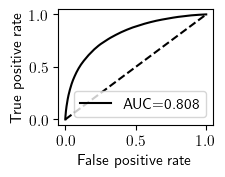

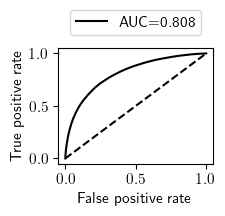


Evaluate_Model() for  BRFC_alpha_0_5_0_0_1_0_1_Hard.csv


-------------------------------------

BRFC_alpha_0_5_0_0_1_0_1_Medium.csv
802700
802700
num_prec =  4
Charts_and_Plots() for  BRFC_alpha_0_5_0_0_1_0_1_Medium.csv
Analyze_Prediction() for  BRFC_alpha_0_5_0_0_1_0_1_Medium.csv
Value_Counts_y_proba() for  BRFC_alpha_0_5_0_0_1_0_1_Medium.csv
FP_P_Locate() for  BRFC_alpha_0_5_0_0_1_0_1_Medium.csv
BRFC_alpha_0_5_0_0_1_0_1_Medium.csv  has  108  custom_cut intervals of minCut 1000
Plot_Prediction() for  BRFC_alpha_0_5_0_0_1_0_1_Medium.csv
Plot_Prediction_Wide() for  BRFC_alpha_0_5_0_0_1_0_1_Medium.csv
Plot_Prediction_Zoom() for  BRFC_alpha_0_5_0_0_1_0_1_Medium.csv
Plot_Prediction_Zoom() for  BRFC_alpha_0_5_0_0_1_0_1_Medium.csv
Plot_Prediction_Zoom() for  BRFC_alpha_0_5_0_0_1_0_1_Medium.csv
Plot_Prediction_Zoom_Wide() for  BRFC_alpha_0_5_0_0_1_0_1_Medium.csv
Plot_Prediction_Zoom_Wide_Right() for  BRFC_alpha_0_5_0_0_1_0_1_Medium.csv
ROC() for  BRFC_alpha_0_5_0_0_1_0_1_Medium.csv
False
Fa

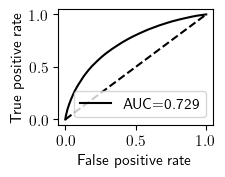

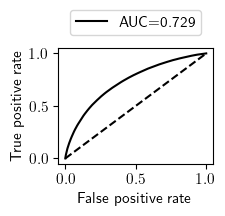


Evaluate_Model() for  BRFC_alpha_0_5_0_0_1_0_1_Medium.csv


-------------------------------------

BRFC_alpha_0_5_0_0_1_0_1_Easy.csv
802700
802700
num_prec =  4
Charts_and_Plots() for  BRFC_alpha_0_5_0_0_1_0_1_Easy.csv
Analyze_Prediction() for  BRFC_alpha_0_5_0_0_1_0_1_Easy.csv
Value_Counts_y_proba() for  BRFC_alpha_0_5_0_0_1_0_1_Easy.csv
FP_P_Locate() for  BRFC_alpha_0_5_0_0_1_0_1_Easy.csv
BRFC_alpha_0_5_0_0_1_0_1_Easy.csv  has  125  custom_cut intervals of minCut 1000
Plot_Prediction() for  BRFC_alpha_0_5_0_0_1_0_1_Easy.csv
Plot_Prediction_Wide() for  BRFC_alpha_0_5_0_0_1_0_1_Easy.csv
Plot_Prediction_Zoom() for  BRFC_alpha_0_5_0_0_1_0_1_Easy.csv
Plot_Prediction_Zoom() for  BRFC_alpha_0_5_0_0_1_0_1_Easy.csv
Plot_Prediction_Zoom() for  BRFC_alpha_0_5_0_0_1_0_1_Easy.csv
Plot_Prediction_Zoom_Wide() for  BRFC_alpha_0_5_0_0_1_0_1_Easy.csv
Plot_Prediction_Zoom_Wide_Right() for  BRFC_alpha_0_5_0_0_1_0_1_Easy.csv
ROC() for  BRFC_alpha_0_5_0_0_1_0_1_Easy.csv
False
False
./Images/Run_0_0_1_0_1

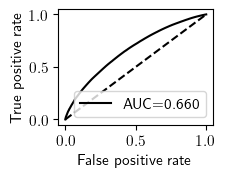

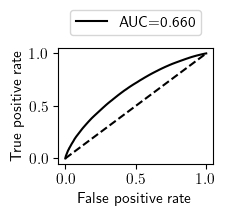


Evaluate_Model() for  BRFC_alpha_0_5_0_0_1_0_1_Easy.csv

CPU times: user 5min 8s, sys: 8.45 s, total: 5min 16s
Wall time: 5min 11s


In [25]:
%%time
Runs = [
    '_0_0_0_0',
    '_0_0_0_1',
    '_0_0_1_0',
    '_0_0_1_1',
    '_0_1_0_0',
    '_0_1_0_1',
    '_0_1_1_0',
    '_0_1_1_1',
    '_1_0_0_0',
    '_1_0_0_1',
    '_1_0_1_0',
    '_1_0_1_1',
    '_1_1_0_0',
    '_1_1_0_1',
    '_1_1_1_0',
    '_1_1_1_1',
]

Runs = ['_0_0_1_0_1']


data_directory = './Analyze_Proba/All'
if not os.path.exists(data_directory):
    os.makedirs(data_directory)
#Create_Files('All')

for run in Runs:
    data_directory = './Analyze_Proba/Run' + run
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)
    images_directory = './Images/Run' + run
    if not os.path.exists(images_directory):
        os.makedirs(images_directory)
    Create_Files('Run' + run)
    Analyze_Results(run)
    
    
        

#CPU times: user 1h 3min 10s, sys: 1min 51s, total: 1h 5min 2s
#Wall time: 1h 3min 56s